# Code for experiments with colored MNIST and Celeba

## 1. Imports

In [1]:
import os
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

from src.enot import SDE, integrate

%matplotlib inline 

import gc
import json
import warnings

import torch
import torch.nn as nn
import wandb
from IPython.display import clear_output

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
from tqdm import tqdm

from src.cunet import CUNet
from src.fid_score import calculate_frechet_distance
from src.plotters import (
    plot_fixed_sde_images,
    plot_fixed_sde_trajectories,
    plot_random_sde_images,
    plot_random_sde_trajectories,
    plot_several_fixed_sde_trajectories,
    plot_several_random_sde_trajectories,
)
from src.resnet2 import ResNet_D
from src.tools import (
    fig2img,  # for wandb
    freeze,
    get_sde_pushed_loader_stats,
    load_dataset,
    unfreeze,
    weights_init_D,
)

LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)
warnings.filterwarnings("ignore")

In [2]:
gc.collect()
torch.cuda.empty_cache()

## 2. Config

Dataset choosing in the first rows

In [3]:
# For Celeba exps
# DATASET1, DATASET1_PATH = "CelebA_low", "/home/zyz/data/img_align_celeba"
# DATASET2, DATASET2_PATH = "CelebA_high", "/home/zyz/data/img_align_celeba"

# For Colored MNIST exps
DATASET1, DATASET1_PATH = "MNIST-colored_2", "/home/zyz/data/MNIST"
DATASET2, DATASET2_PATH = "MNIST-colored_3", "/home/zyz/data/MNIST"

# We use epsilon in [0, 1, 10]
EPSILON = 1

# N steps in the Euler-Maruyama
N_STEPS = 10

# GPU choosing
DEVICE_IDS = [1, 2, 3]

# All hyperparameters below is set to the values used for the experiments, which discribed in the article

T_ITERS = 10
D_LR, T_LR = 1e-4, 1e-4
BETA_D, BETA_T = 0.9, 0.9
IMG_SIZE = 32
UNET_BASE_FACTOR = 128

TIME_DIM = 128
CONSTANT_TIME = False
USE_POSITIONAL_ENCODING = True
RESNET_GENERATOR = False
INTEGRAL_SCALE = 1 / (3 * IMG_SIZE * IMG_SIZE)
ONE_STEP_INIT_ITERS = 0
T_GRADIENT_MAX_NORM = float("inf")
D_GRADIENT_MAX_NORM = float("inf")
PREDICT_SHIFT = True
SMART_INTERVALS = False
INTERVAL_SHRINK_START_TIME = 0.98
LAST_STEP_NOISE_STD = 1e-3
USE_GRADIENT_CHECKPOINT = False
PREDICT_NOISE_AT_LAST_STEP = False
N_LAST_STEPS_WITHOUT_NOISE = 1
TRACK_VAR_INTERVAL = 10
IMPROVED_DIFFUSION = False
USE_CHECKPOINTS_INSIDE_MODEL = False
EPSILON_SCHEDULER_LAST_ITER = 20000
USE_EXPONENTIAL_AVERAGE_MODEL = False
DISTINCT_SHIFT_MODELS = False
IMAGE_INPUT = True

DATASET1_CHANNELS = 3
DATASET2_CHANNELS = 3
GRAY_PLOTS = False
BATCH_SIZE = 64
STEPS_TO_SHOW = 10

PLOT_INTERVAL = 500
COST = "schrodinger"
CPKT_INTERVAL = 500
# MAX_STEPS = 100001
MAX_STEPS = 5001
SEED = 0xBADBEEF

GAMMA0, GAMMA1 = 0.0, 0.333
GAMMA_ITERS = 20000

CONTINUE = -1

In [4]:
EXP_NAME = f"{DATASET1}_{DATASET2}_INTEGRAL_SCALE_{round(INTEGRAL_SCALE, 5)}"
OUTPUT_PATH = "../checkpoints/{}/{}/{}_{}_{}/".format(
    COST, EXP_NAME, DATASET1, DATASET2, IMG_SIZE
)

In [5]:
config = dict(
    SEED=SEED,
    DATASET1=DATASET1,
    DATASET2=DATASET2,
    T_ITERS=T_ITERS,
    D_LR=D_LR,
    T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE,
    UNET_BASE_FACTOR=UNET_BASE_FACTOR,
    N_STEPS=N_STEPS,
    EPSILON=EPSILON,
    CONSTANT_TIME=CONSTANT_TIME,
    USE_POSITIONAL_ENCODING=USE_POSITIONAL_ENCODING,
    TIME_DIM=TIME_DIM,
    RESNET_GENERATOR=RESNET_GENERATOR,
    INTEGRAL_SCALE=INTEGRAL_SCALE,
    ONE_STEP_INIT_ITERS=ONE_STEP_INIT_ITERS,
    T_GRADIENT_MAX_NORM=T_GRADIENT_MAX_NORM,
    D_GRADIENT_MAX_NORM=D_GRADIENT_MAX_NORM,
    PREDICT_SHIFT=PREDICT_SHIFT,
    SMART_INTERVALS=SMART_INTERVALS,
    INTERVAL_SHRINK_START_TIME=INTERVAL_SHRINK_START_TIME,
    LAST_STEP_NOISE_STD=LAST_STEP_NOISE_STD,
    USE_GRADIENT_CHECKPOINT=USE_GRADIENT_CHECKPOINT,
    PREDICT_NOISE_AT_LAST_STEP=PREDICT_NOISE_AT_LAST_STEP,
    N_LAST_STEPS_WITHOUT_NOISE=N_LAST_STEPS_WITHOUT_NOISE,
    TRACK_VAR_INTERVAL=TRACK_VAR_INTERVAL,
    IMPROVED_DIFFUSION=IMPROVED_DIFFUSION,
    USE_CHECKPOINTS_INSIDE_MODEL=USE_CHECKPOINTS_INSIDE_MODEL,
    EPSILON_SCHEDULER_LAST_ITER=EPSILON_SCHEDULER_LAST_ITER,
    USE_EXPONENTIAL_AVERAGE_MODEL=USE_EXPONENTIAL_AVERAGE_MODEL,
    DISTINCT_SHIFT_MODELS=DISTINCT_SHIFT_MODELS,
)

AUGMENTED_DATASETS = ["dtd"]
FID_EPOCHS = 50 if DATASET1 in AUGMENTED_DATASETS else 1

assert torch.cuda.is_available()
torch.cuda.set_device(f"cuda:{DEVICE_IDS[0]}")
torch.manual_seed(SEED)
np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

## 3. Initialize samplers

In [6]:
filename = "../stats/{}_{}_test.json".format(DATASET2, IMG_SIZE)
with open(filename, "r") as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats["mu"], data_stats["sigma"]
del data_stats

In [7]:
X_sampler, X_test_sampler = load_dataset(
    DATASET1, DATASET1_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=8
)
Y_sampler, Y_test_sampler = load_dataset(
    DATASET2, DATASET2_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=8
)

torch.cuda.empty_cache()
gc.collect()
clear_output()

## 4. Training

### Models initialization

In [8]:
D = ResNet_D(IMG_SIZE, nc=DATASET2_CHANNELS).cuda()
D.apply(weights_init_D)

T = CUNet(
    DATASET1_CHANNELS, DATASET2_CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR
).cuda()

T = SDE(
    shift_model=T,
    epsilon=EPSILON,
    n_steps=N_STEPS,
    time_dim=TIME_DIM,
    n_last_steps_without_noise=N_LAST_STEPS_WITHOUT_NOISE,
    use_positional_encoding=USE_POSITIONAL_ENCODING,
    use_gradient_checkpoint=USE_GRADIENT_CHECKPOINT,
    predict_shift=PREDICT_SHIFT,
    image_input=IMAGE_INPUT,
).cuda()

if len(DEVICE_IDS) > 1 and CONTINUE == -1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    D = nn.DataParallel(D, device_ids=DEVICE_IDS)

print("T params:", np.sum([np.prod(p.shape) for p in T.parameters()]))
print("D params:", np.sum([np.prod(p.shape) for p in D.parameters()]))

T params: 69568131
D params: 13494209


In [9]:
T_opt = torch.optim.Adam(
    T.parameters(), lr=T_LR, weight_decay=1e-10, betas=(BETA_T, 0.999)
)
D_opt = torch.optim.Adam(
    D.parameters(), lr=D_LR, weight_decay=1e-10, betas=(BETA_D, 0.999)
)
T_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    T_opt, milestones=[15000, 25000, 40000, 55000, 70000], gamma=0.5
)
D_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    D_opt, milestones=[15000, 25000, 40000, 55000, 70000], gamma=0.5
)

if CONTINUE > -1:
    T_opt.load_state_dict(
        torch.load(os.path.join(OUTPUT_PATH, f"T_opt_{SEED}_{CONTINUE}.pt"))
    )
    T_scheduler.load_state_dict(
        torch.load(os.path.join(OUTPUT_PATH, f"T_scheduler_{SEED}_{CONTINUE}.pt"))
    )

    T.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f"T_{SEED}_{CONTINUE}.pt")))
    D.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f"D_{SEED}_{CONTINUE}.pt")))

    if len(DEVICE_IDS) > 1:
        T = nn.DataParallel(T, device_ids=DEVICE_IDS)
        D = nn.DataParallel(D, device_ids=DEVICE_IDS)

    D_opt.load_state_dict(
        torch.load(os.path.join(OUTPUT_PATH, f"D_opt_{SEED}_{CONTINUE}.pt"))
    )
    D_scheduler.load_state_dict(
        torch.load(os.path.join(OUTPUT_PATH, f"D_scheduler_{SEED}_{CONTINUE}.pt"))
    )

In [10]:
torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
X_fixed, Y_fixed = X_sampler.sample(10), Y_sampler.sample(10)

X_test_fixed, Y_test_fixed = X_test_sampler.sample(10), Y_test_sampler.sample(10)

In [11]:
wandb.init(name=EXP_NAME, config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


### Main training cycle and logging

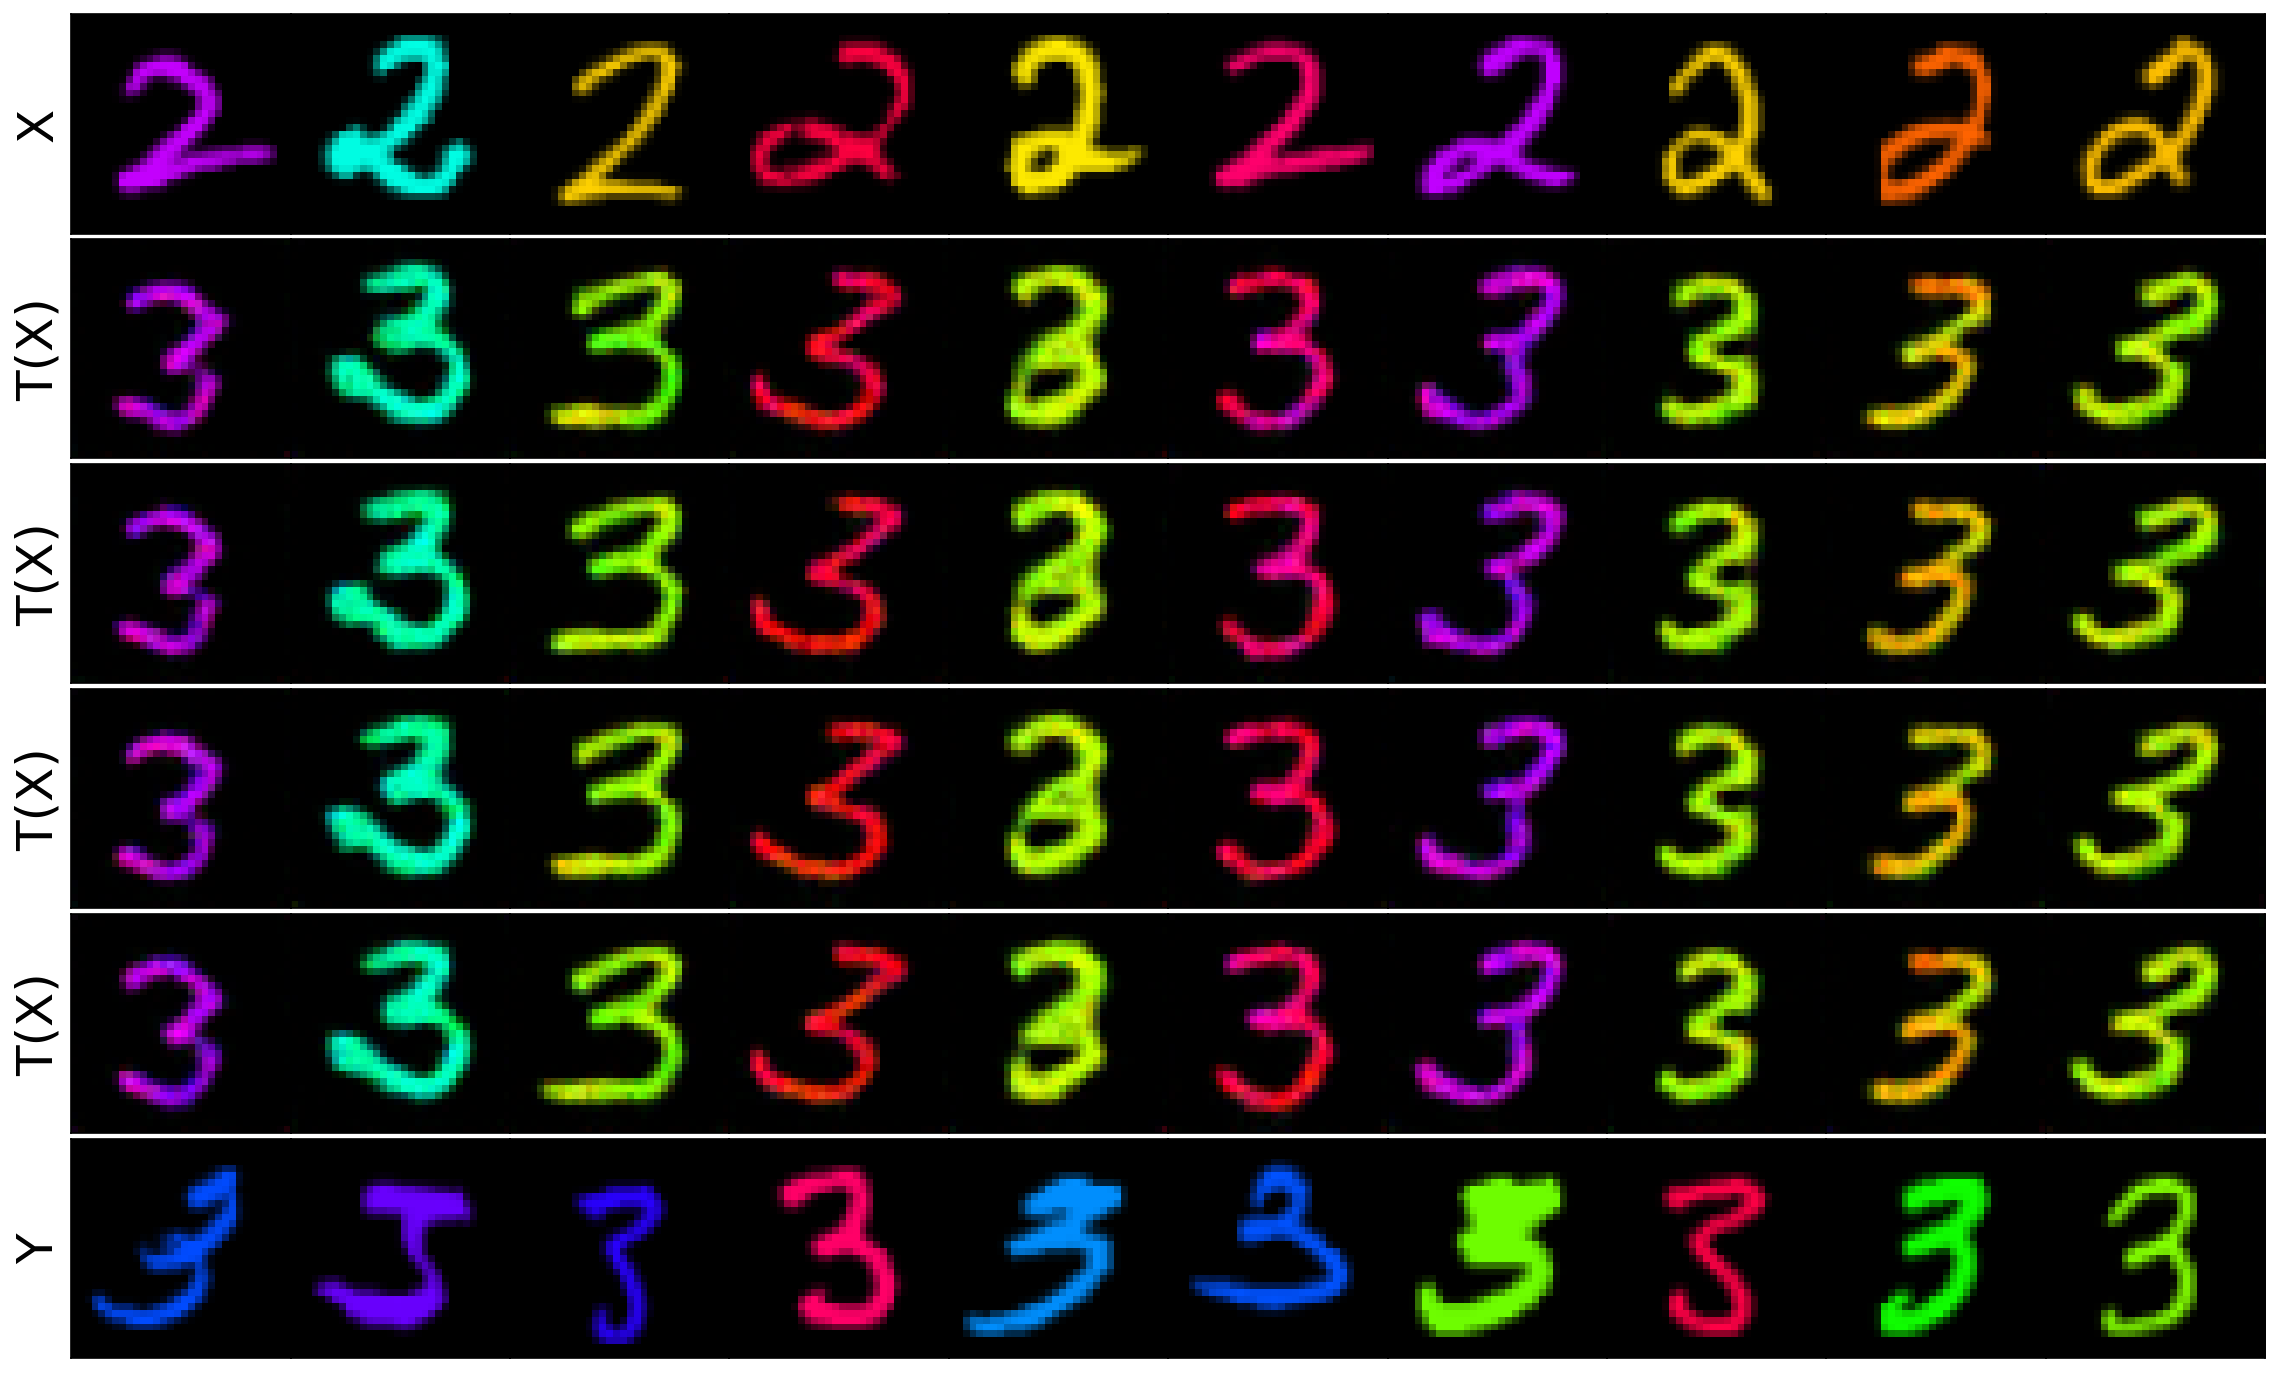

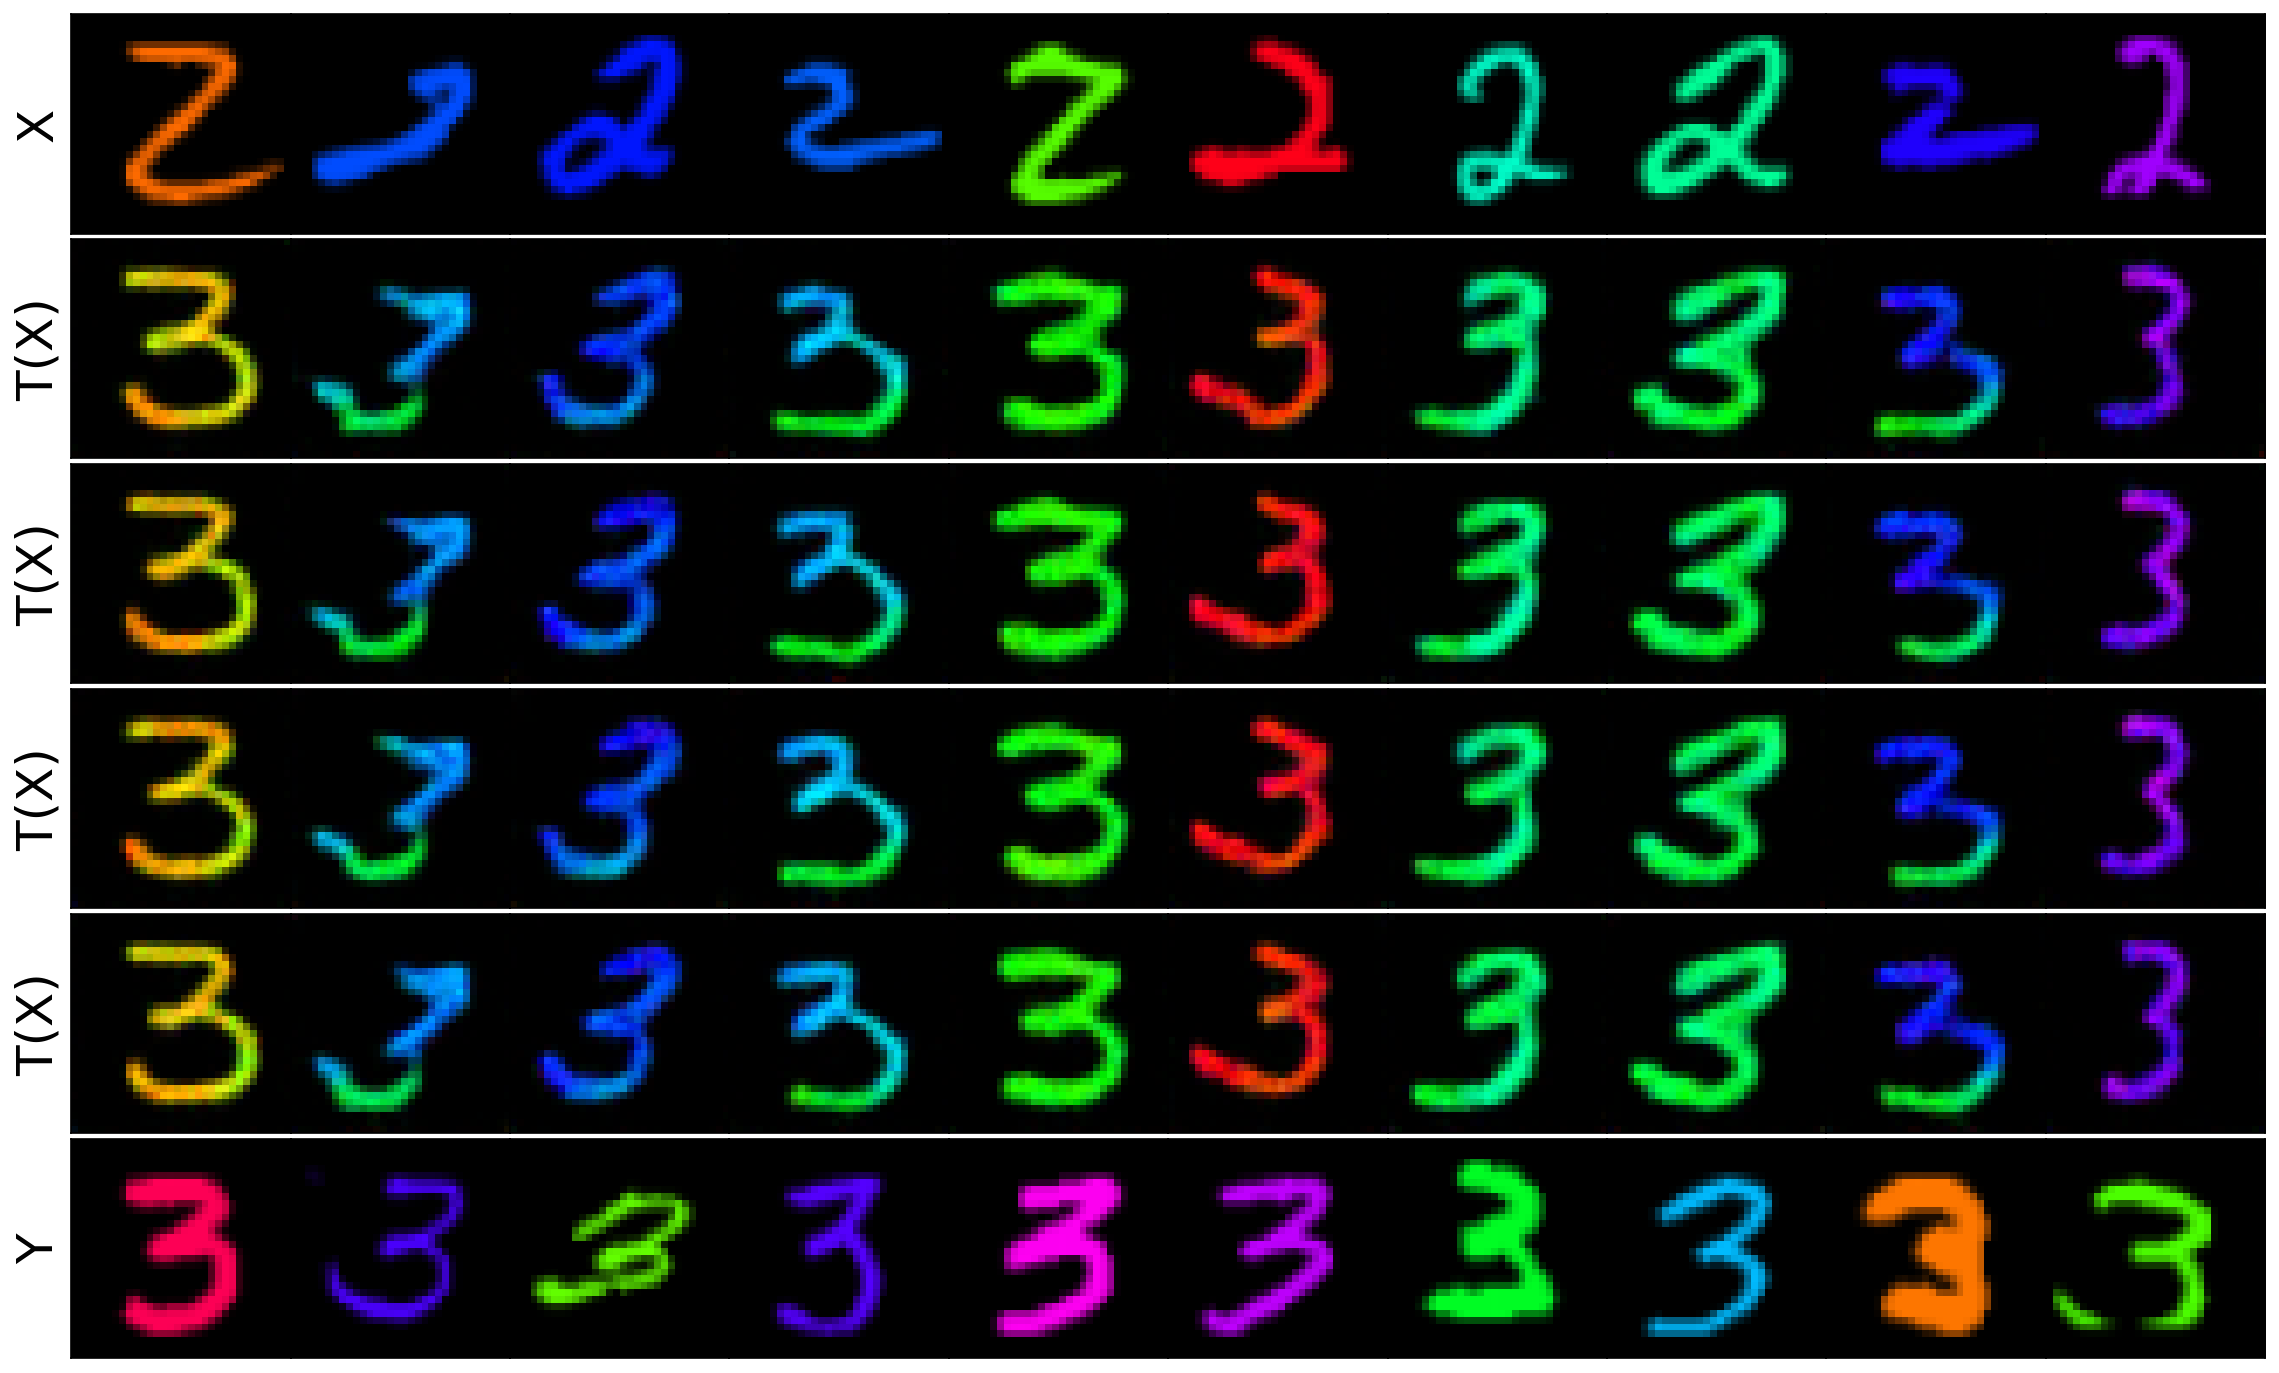

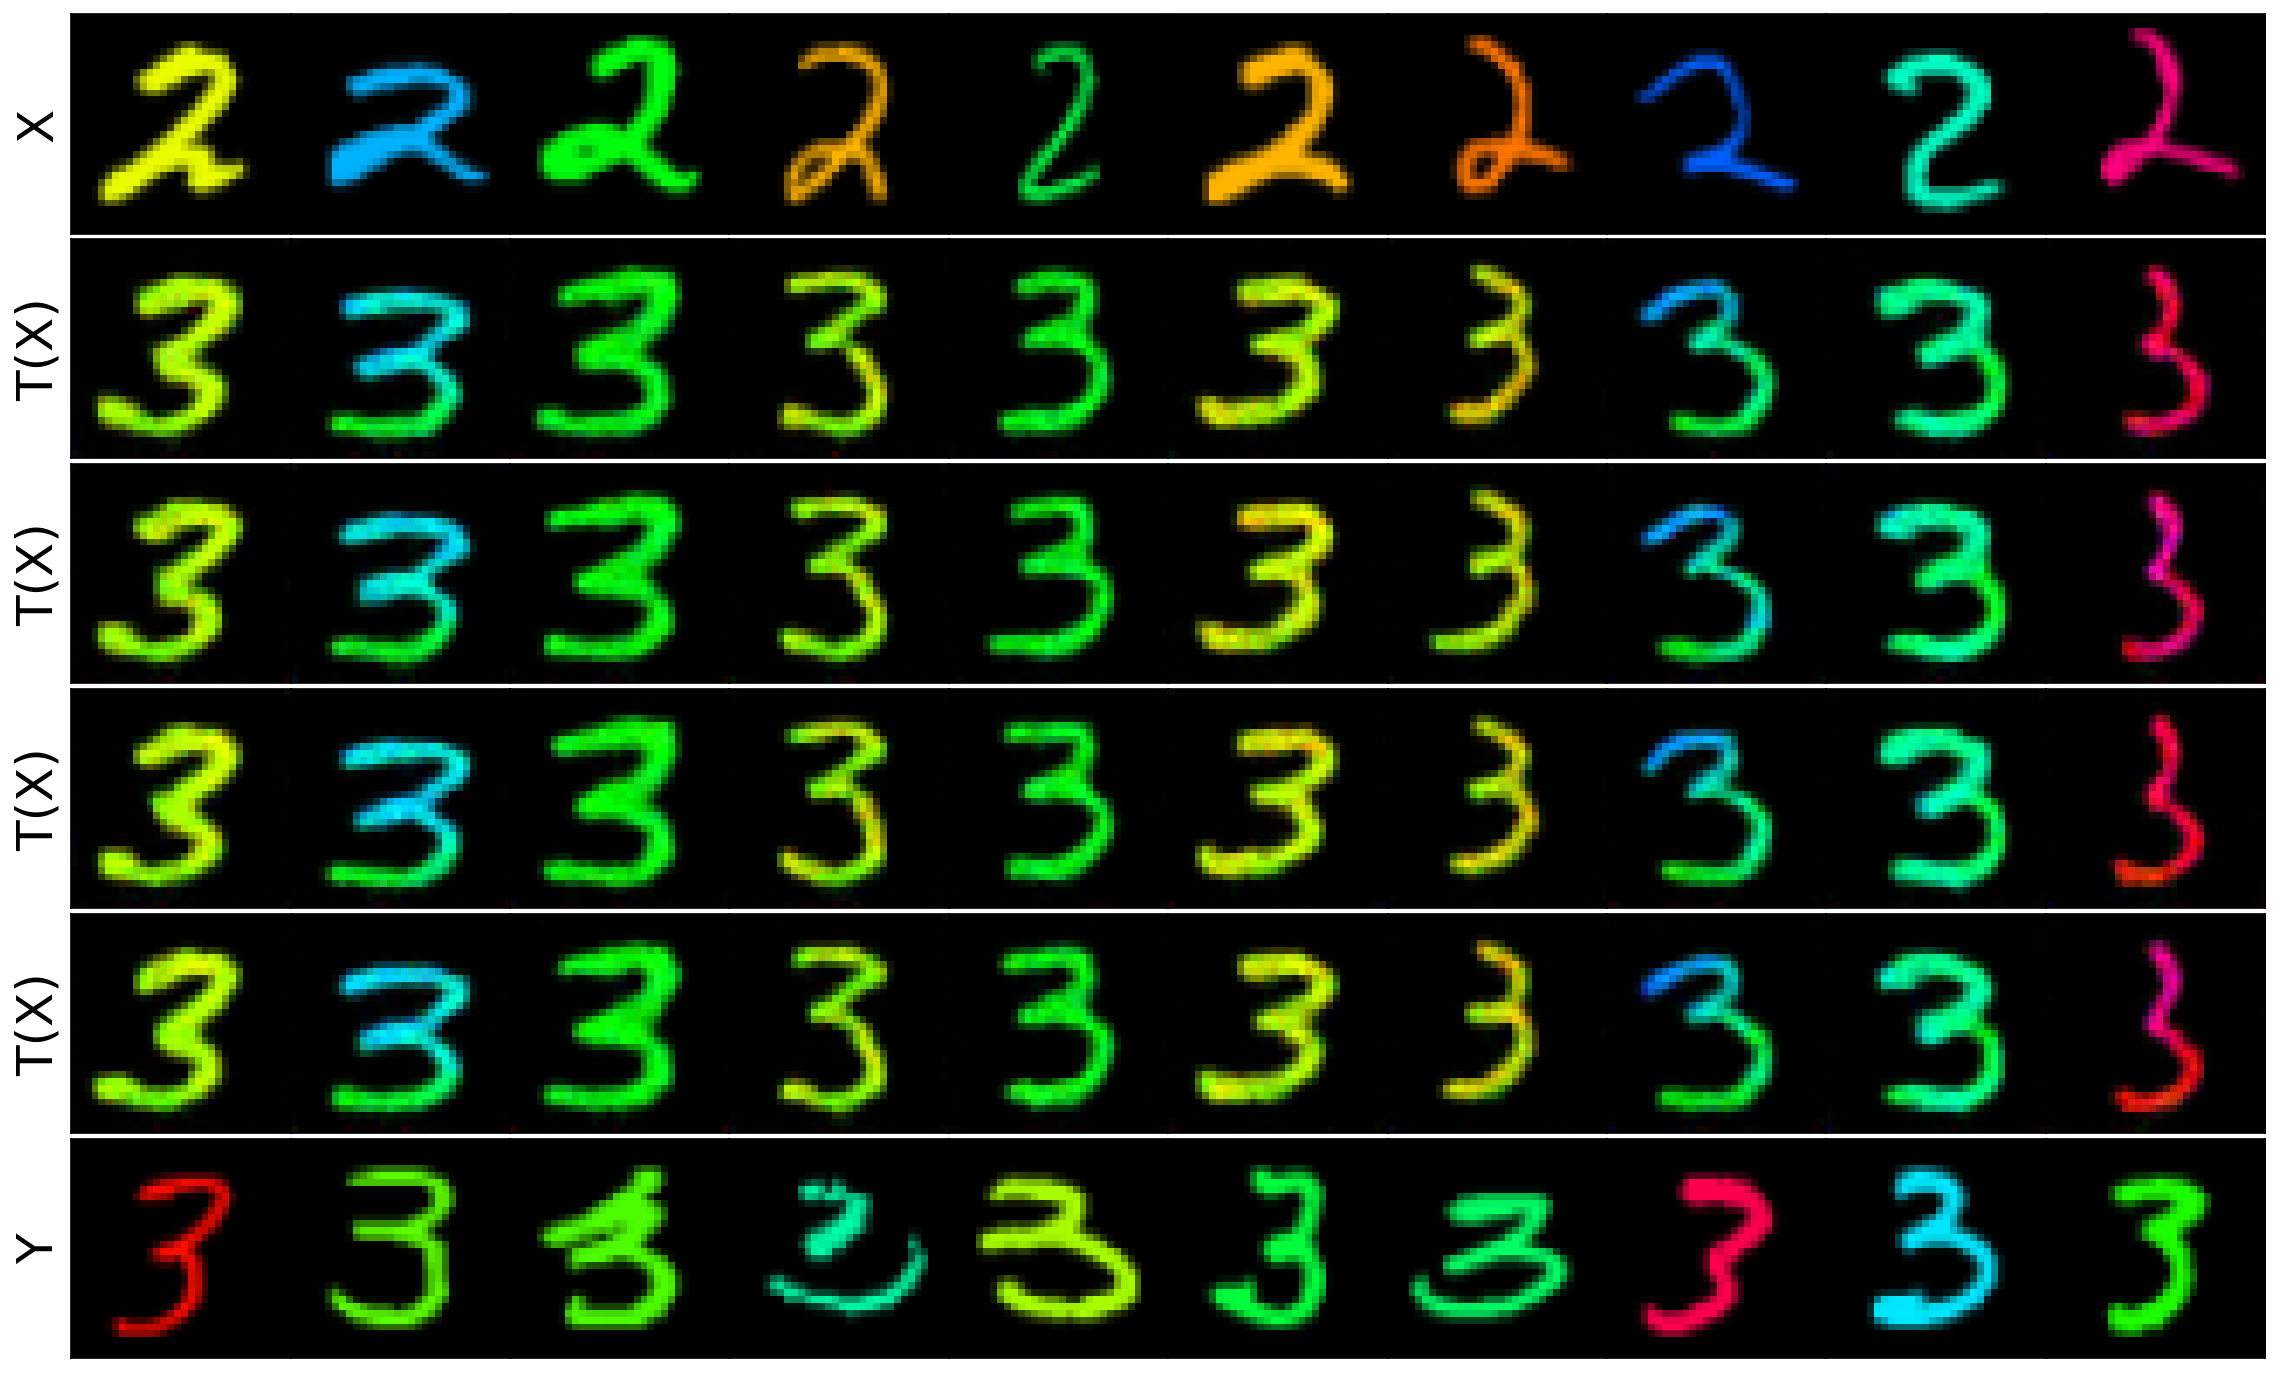

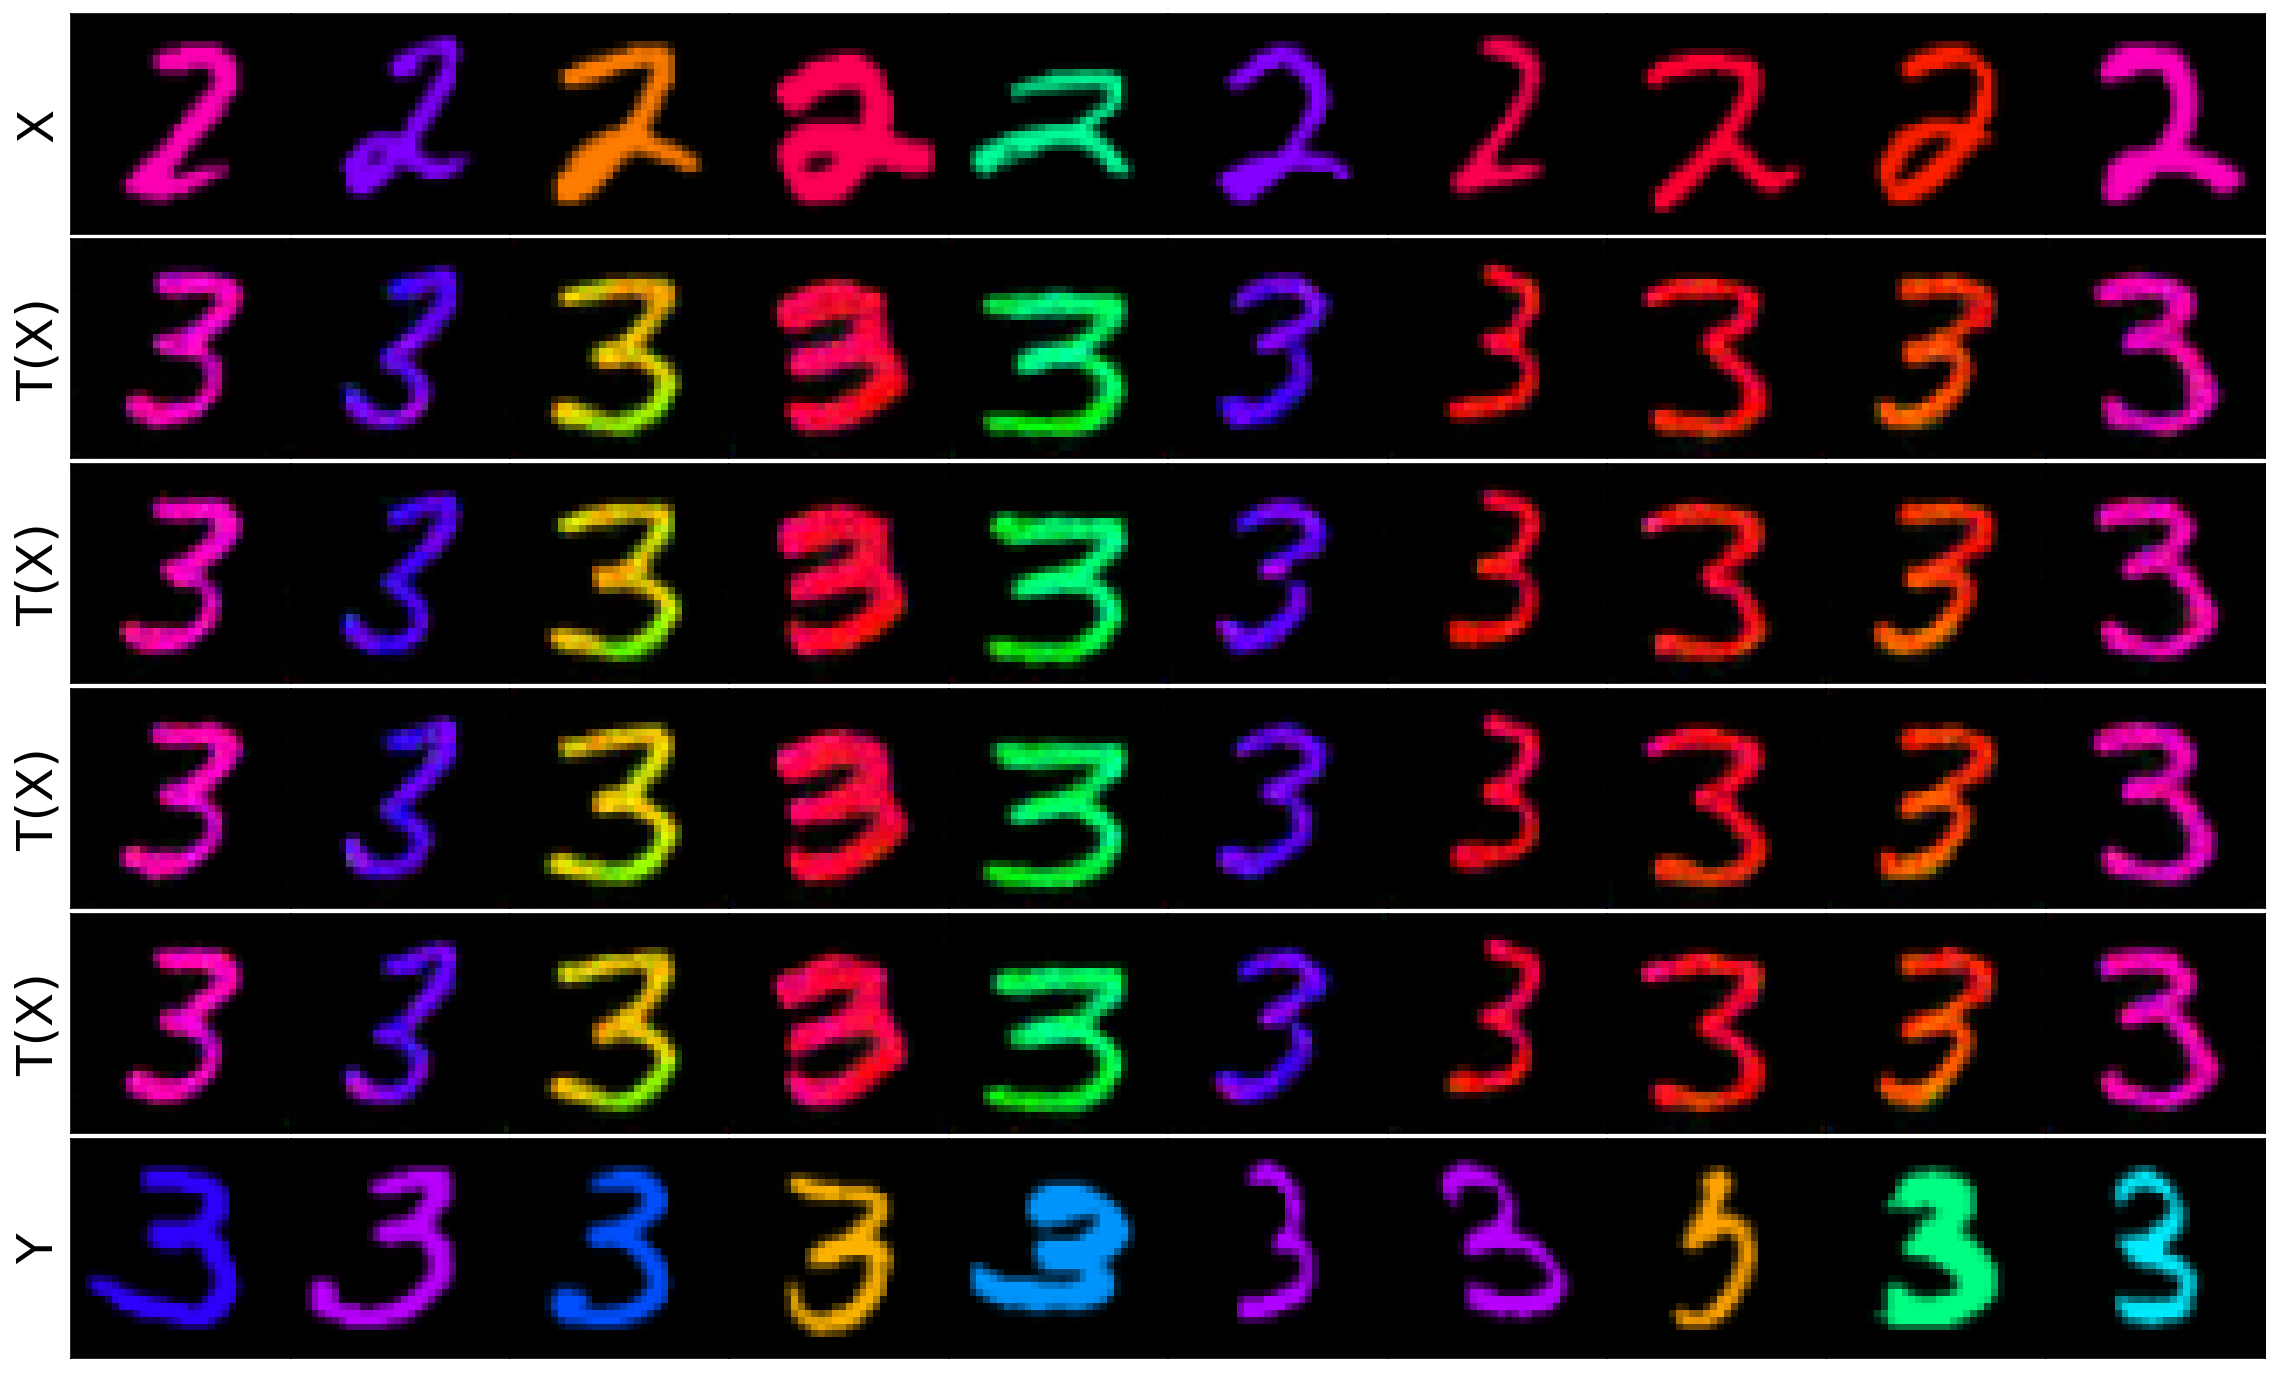

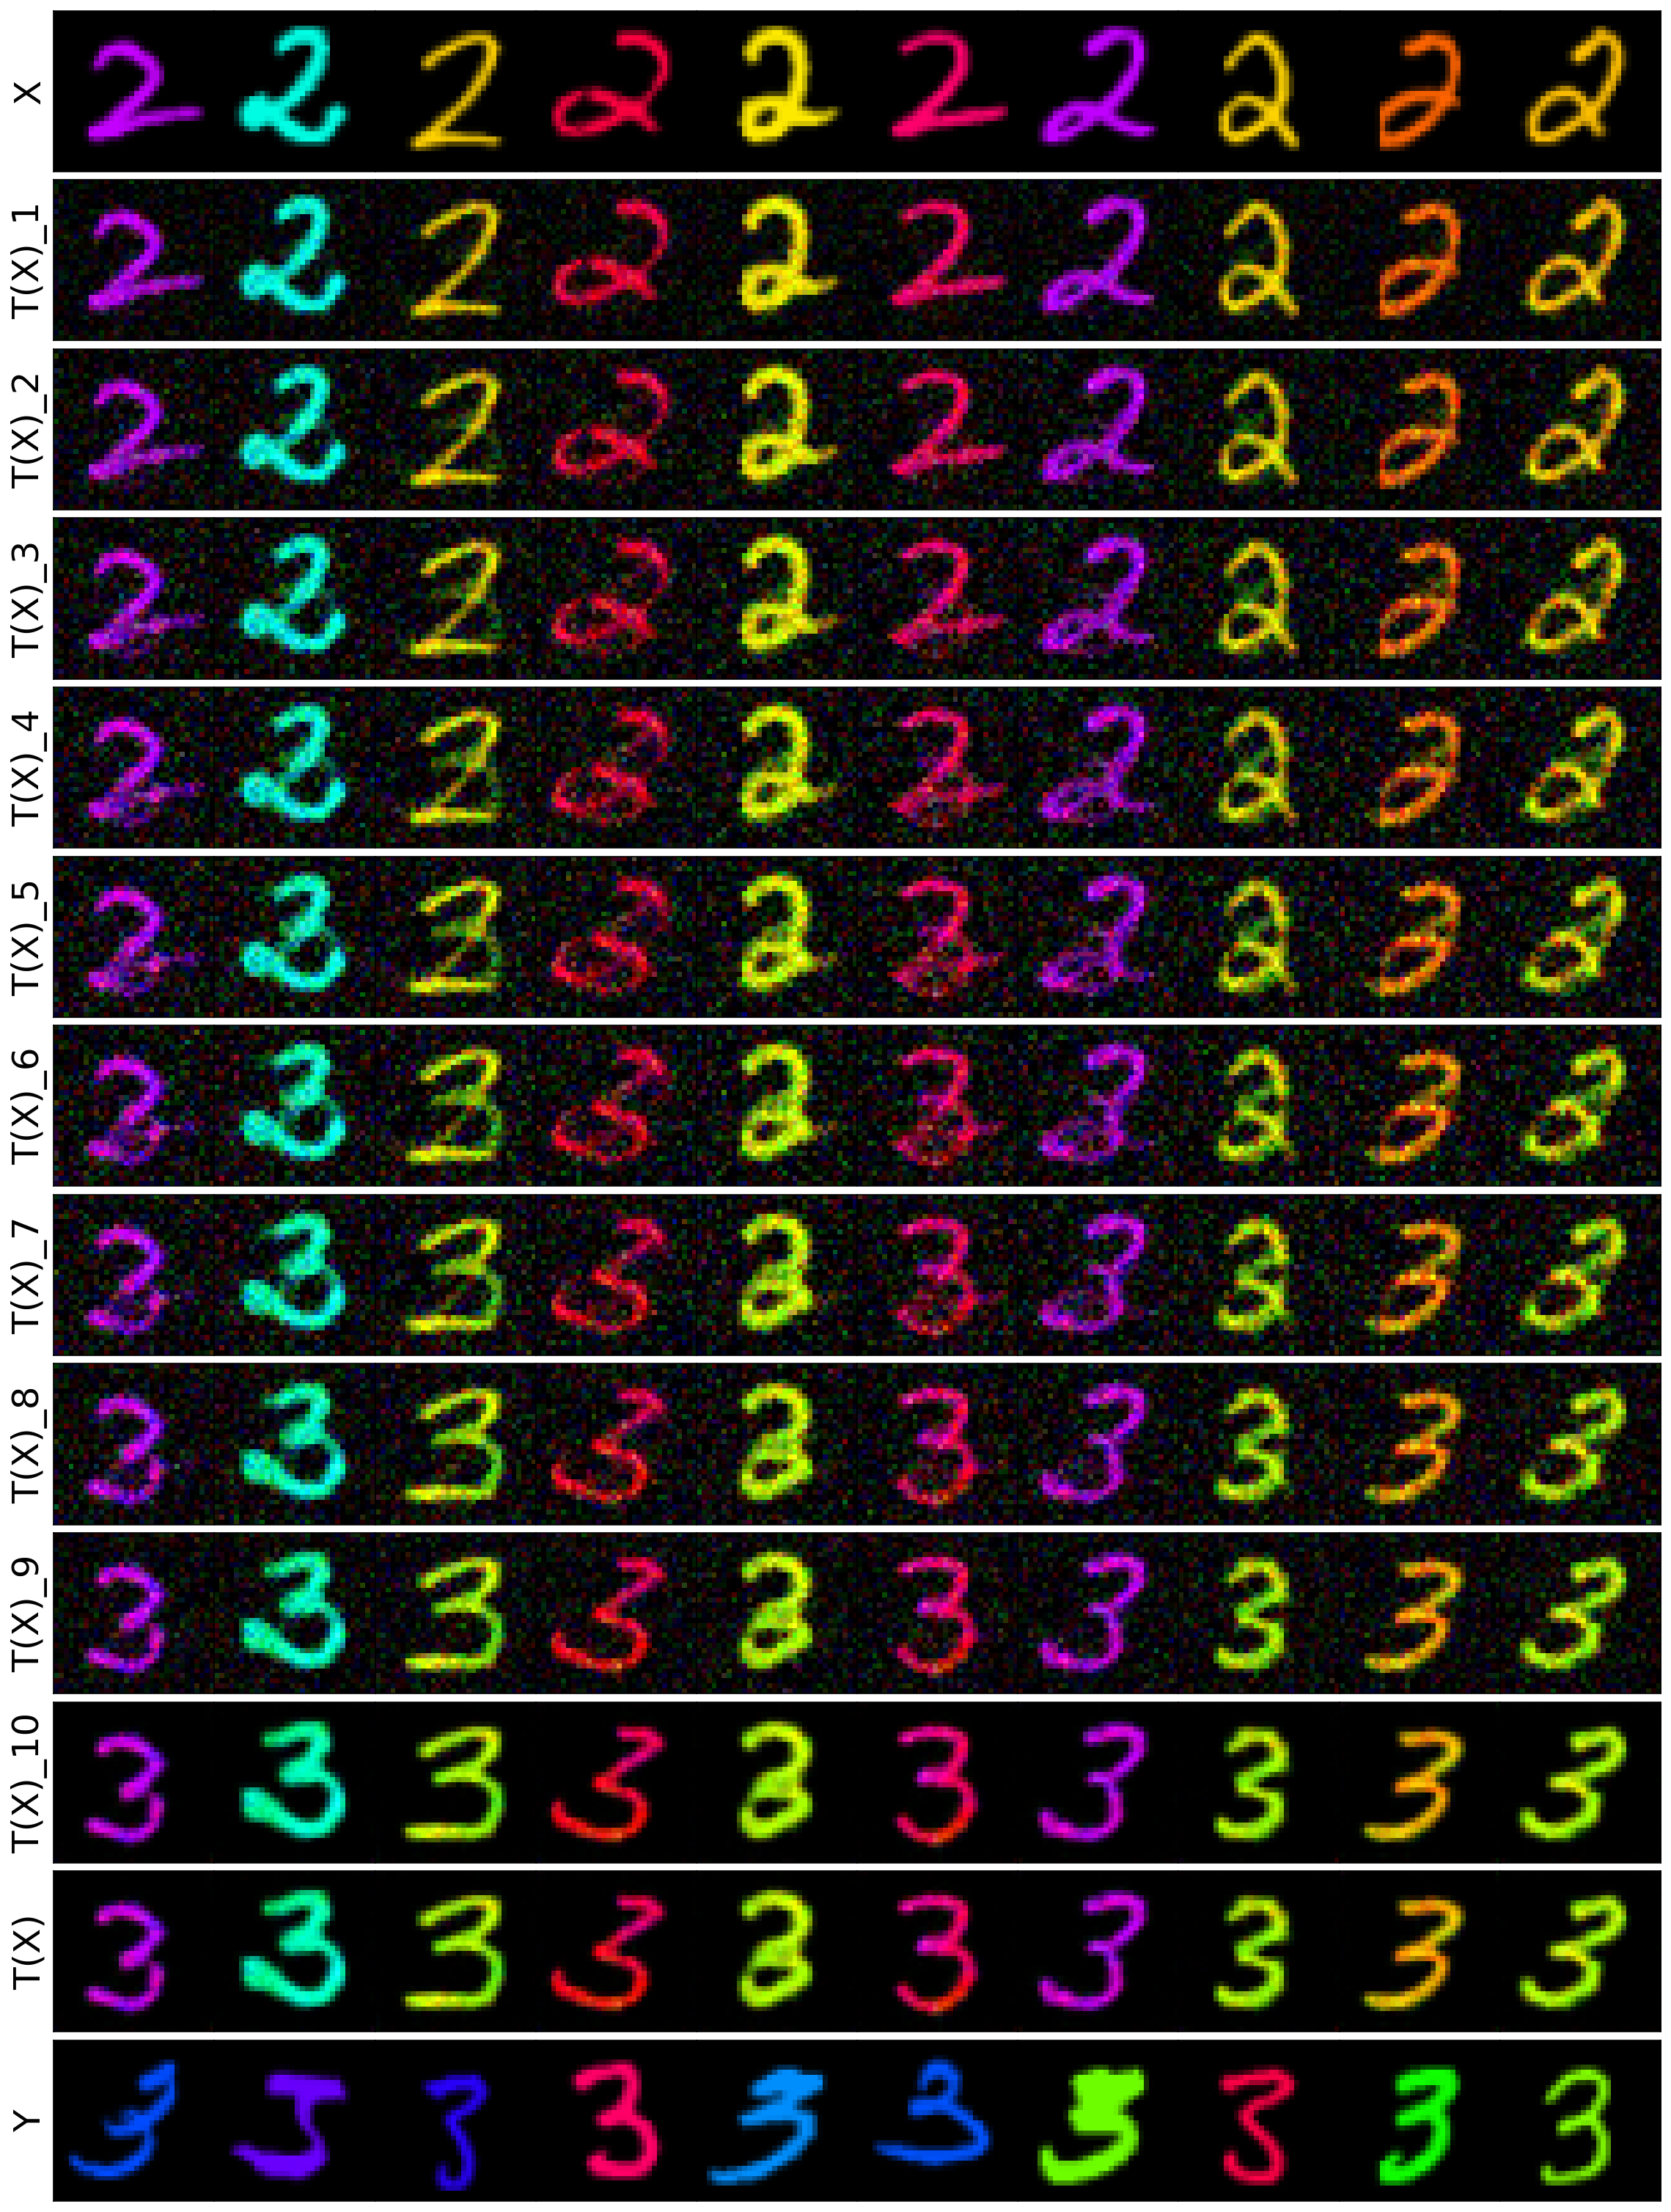

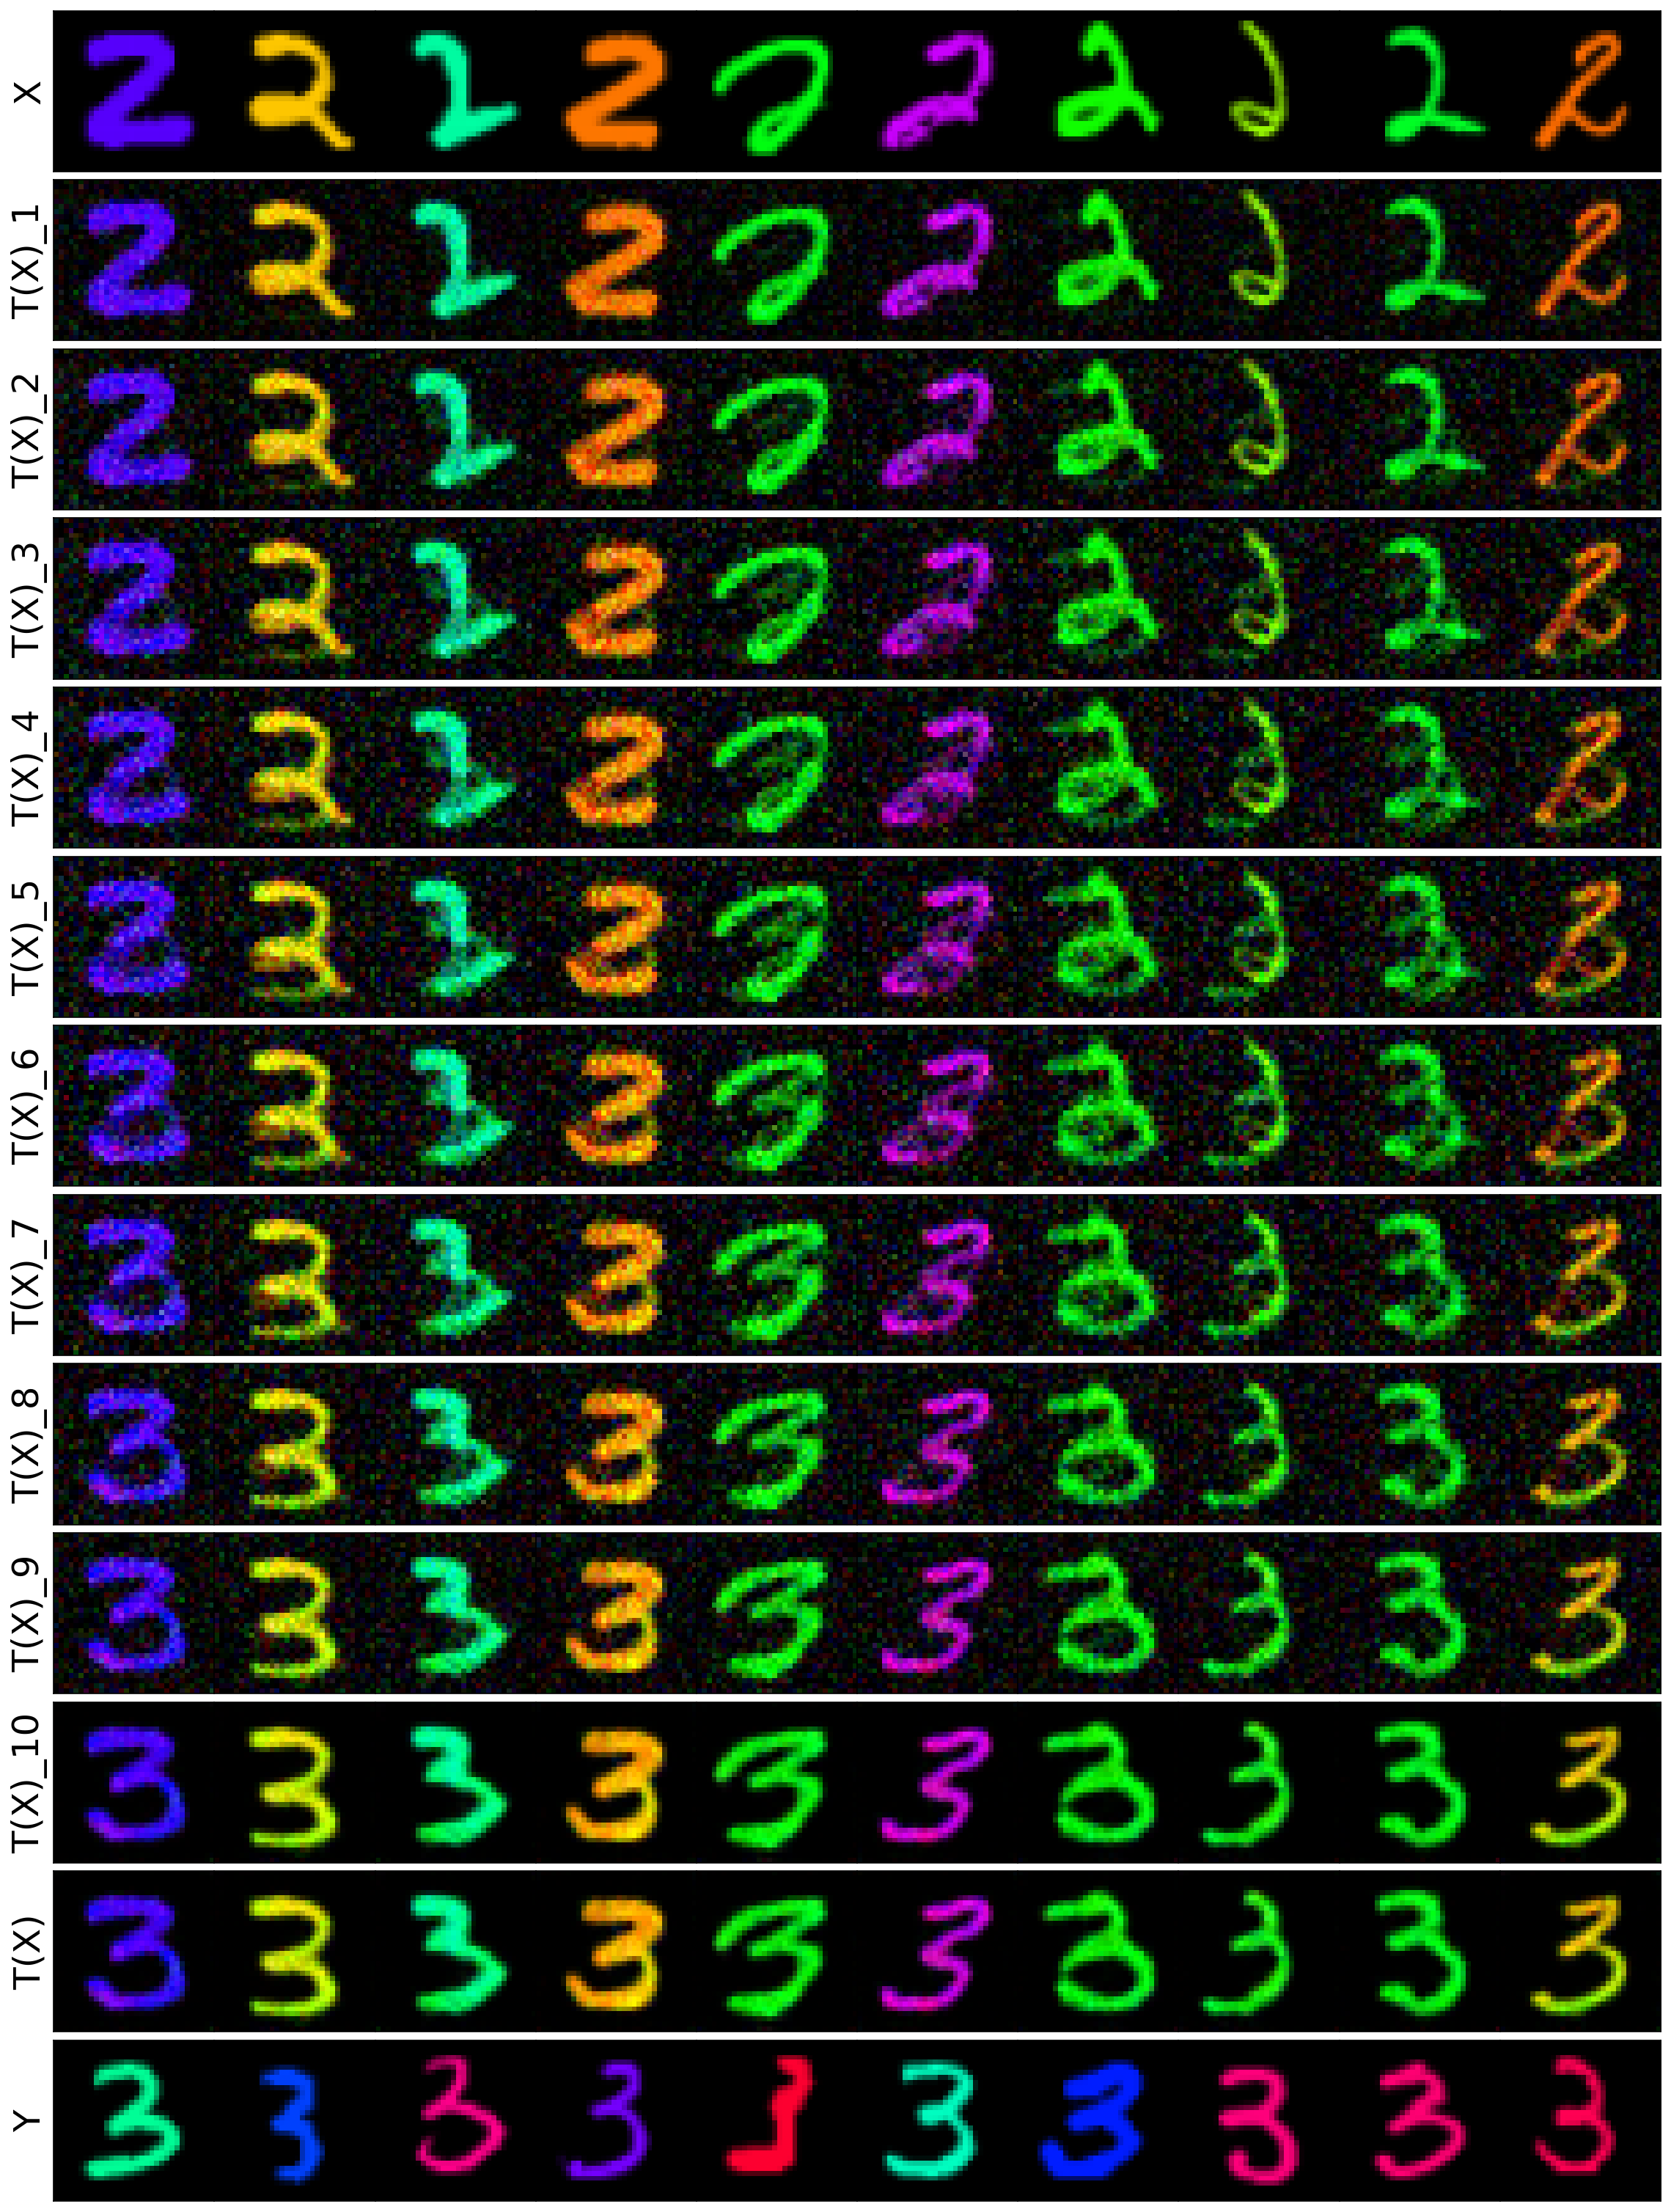

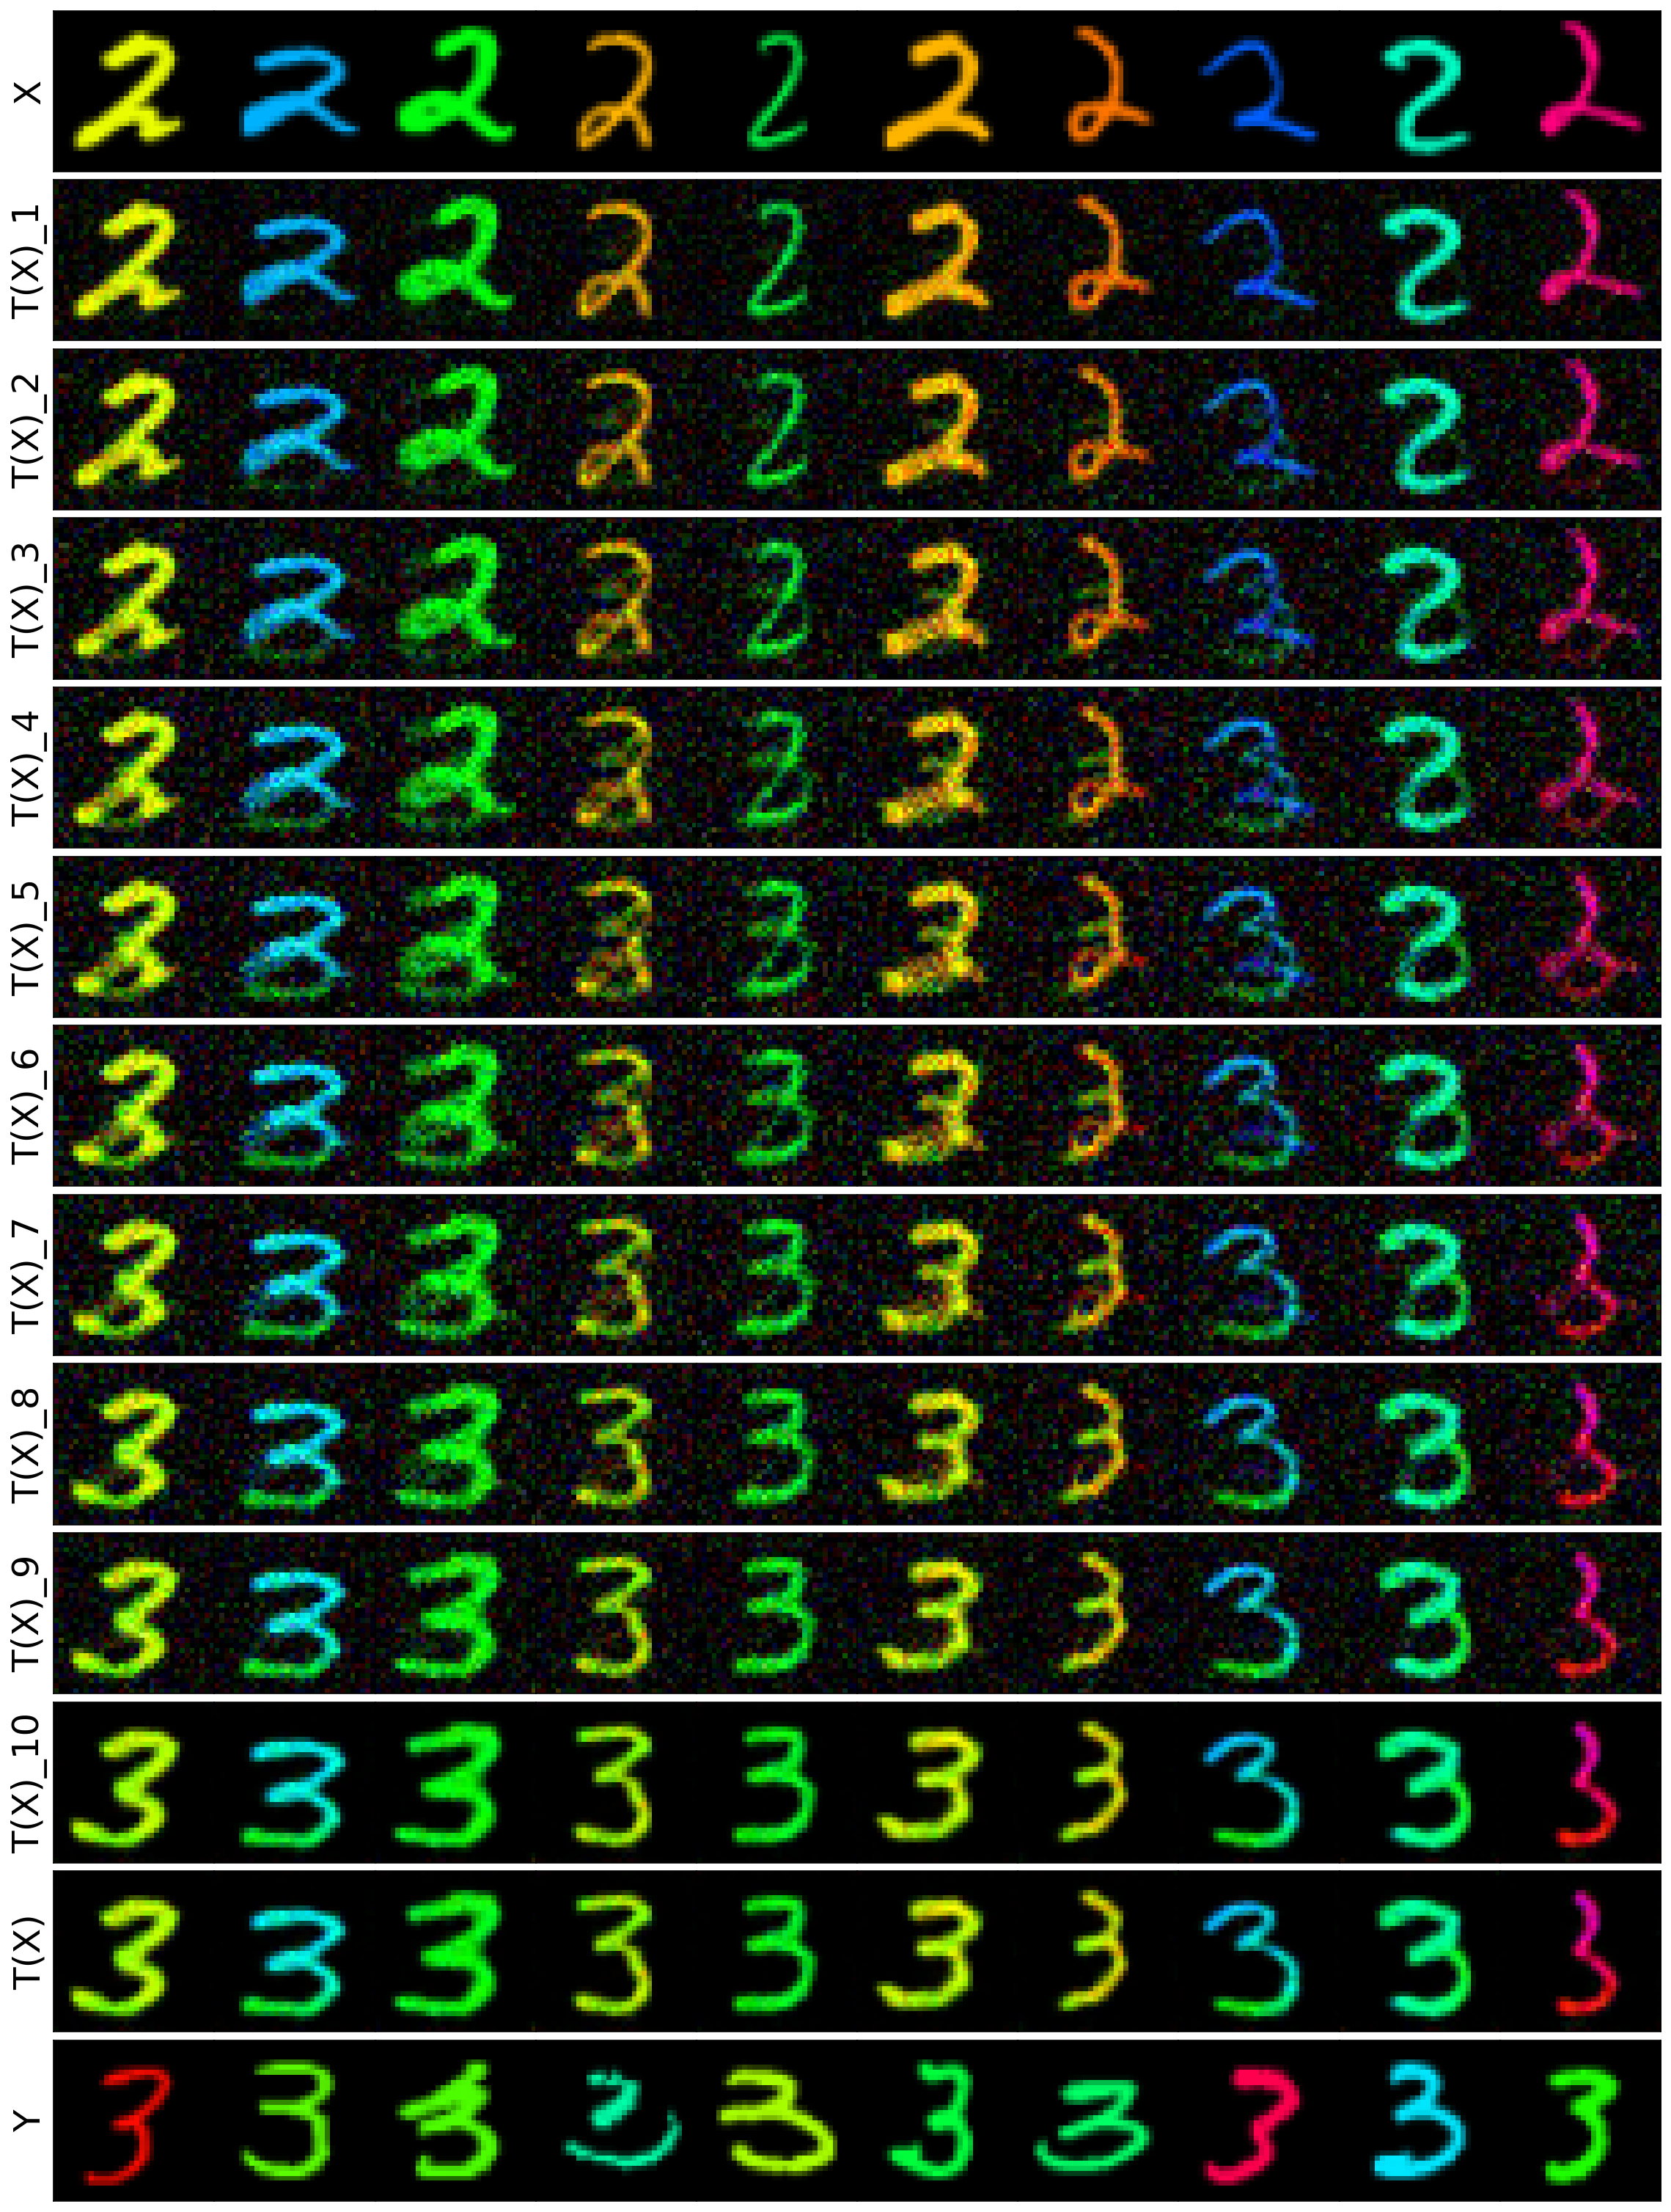

wandb: Network error (ReadTimeout), entering retry loop.


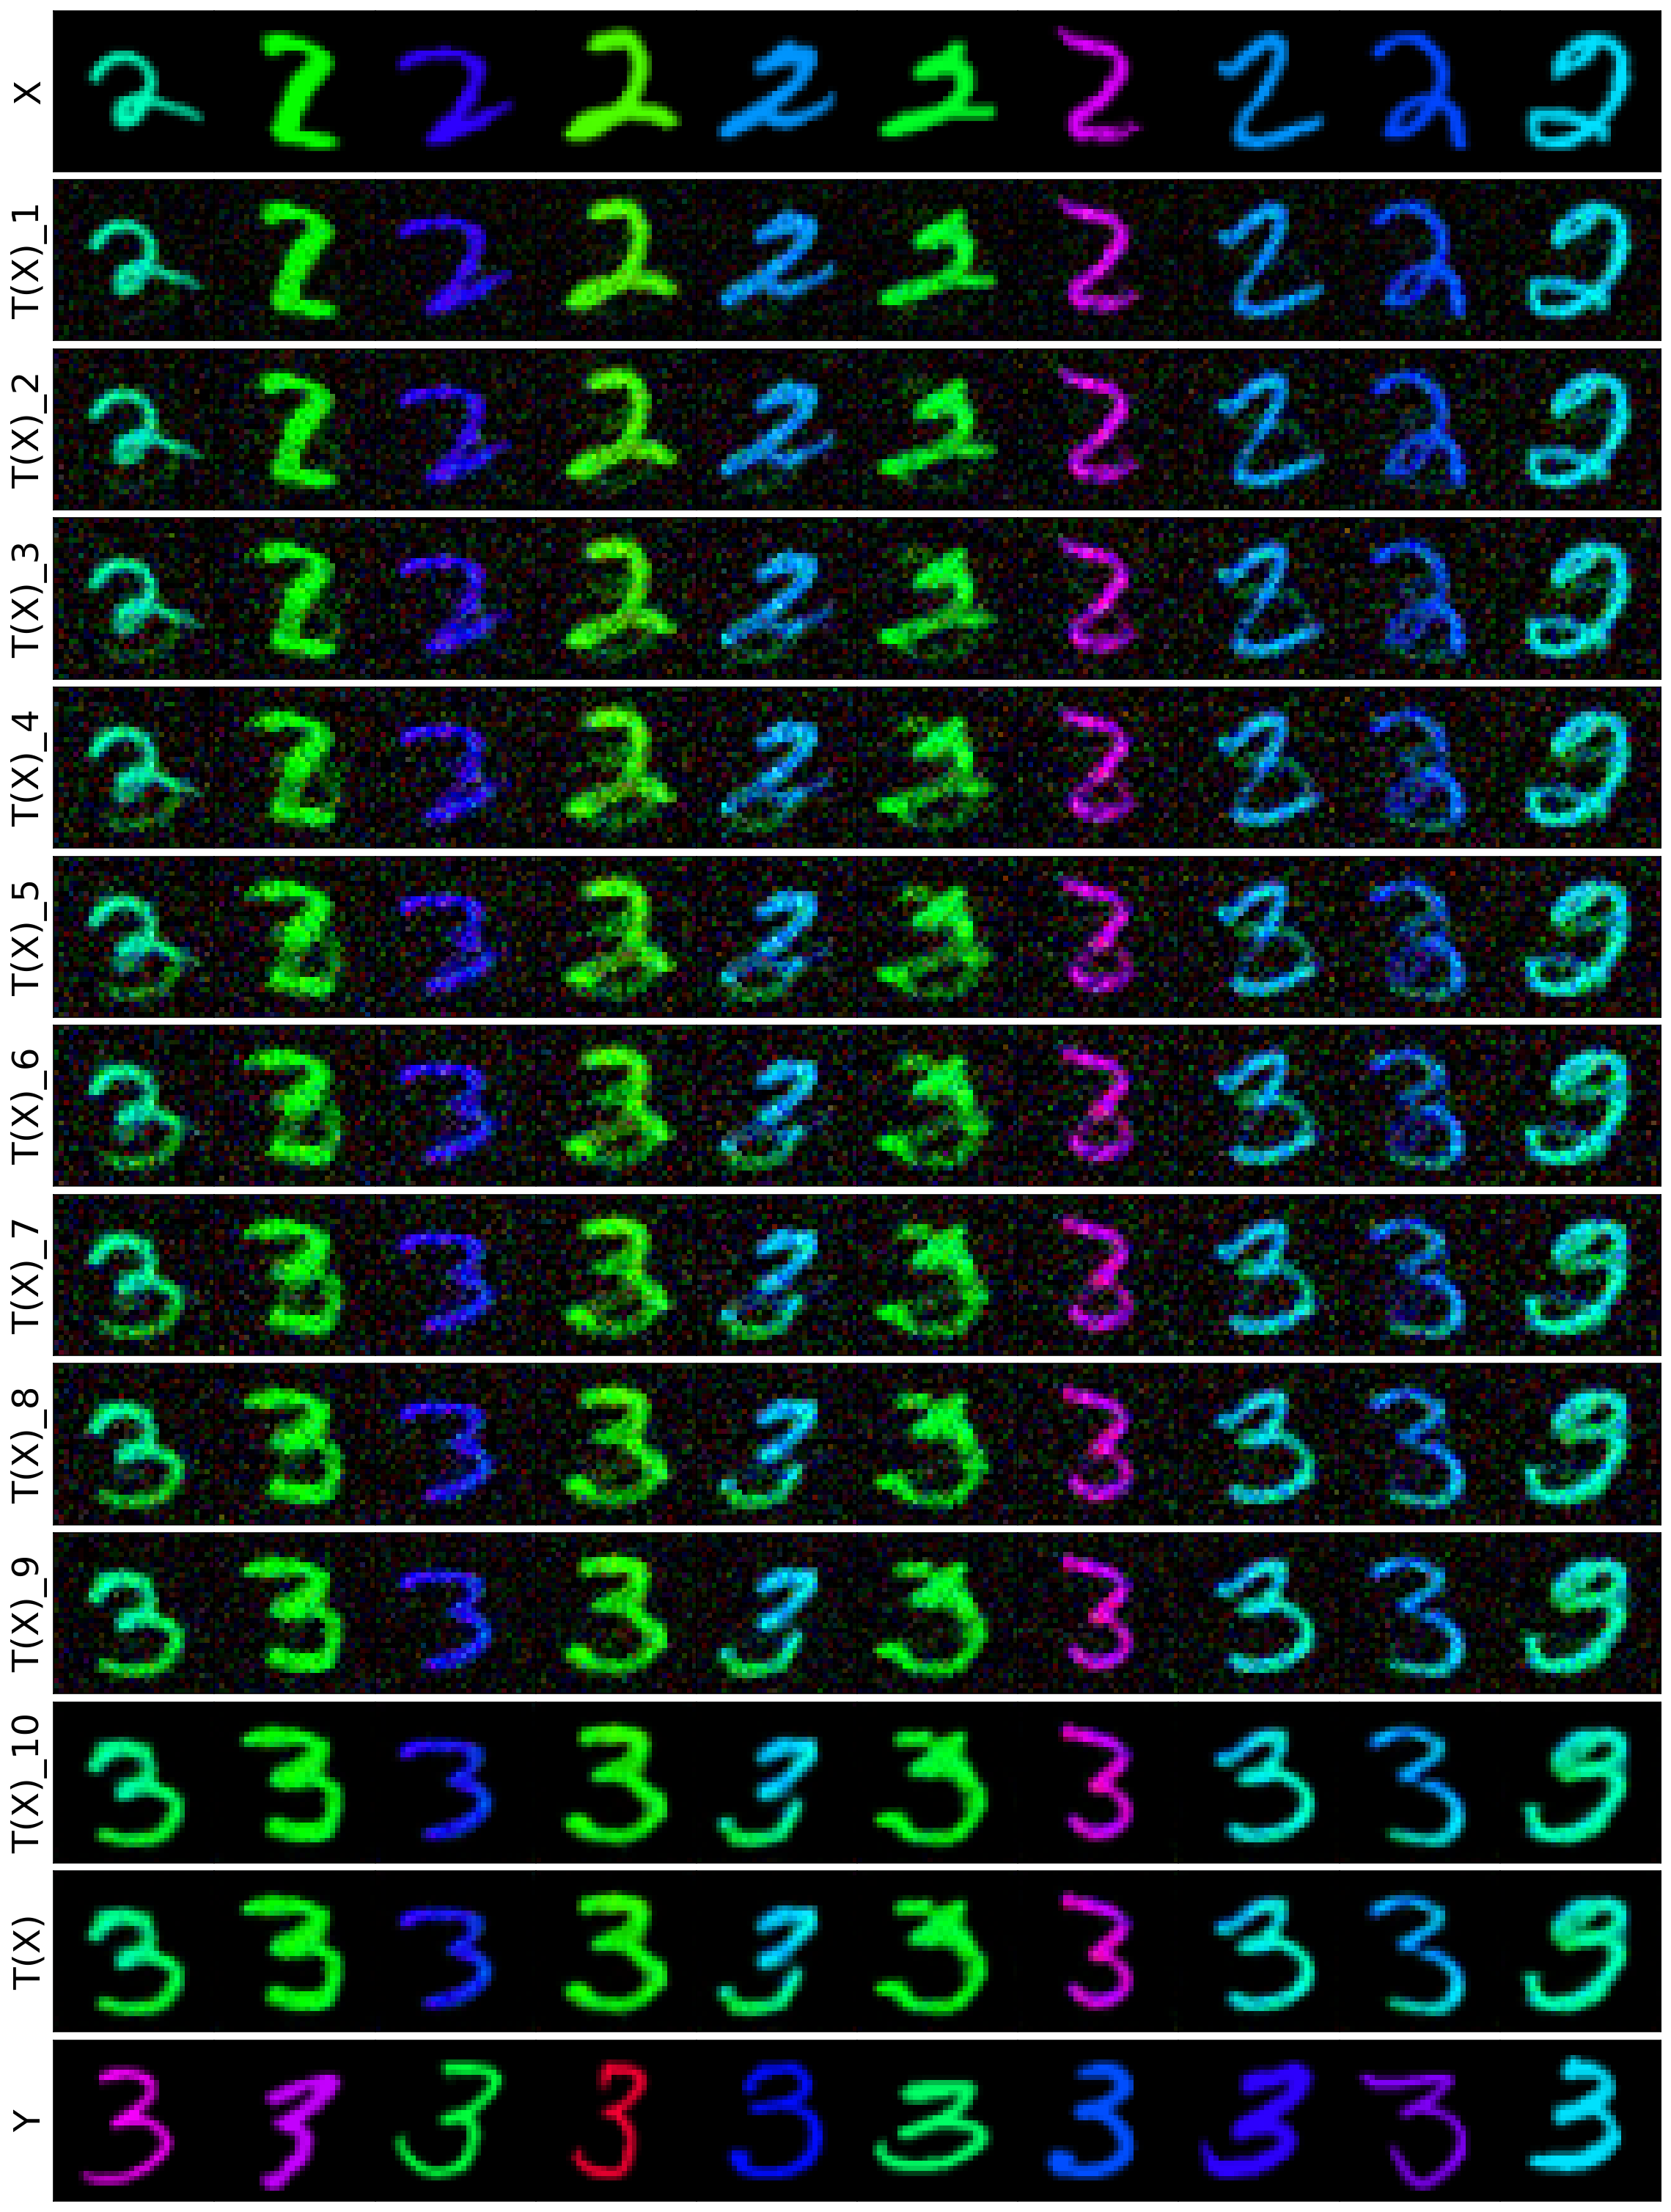

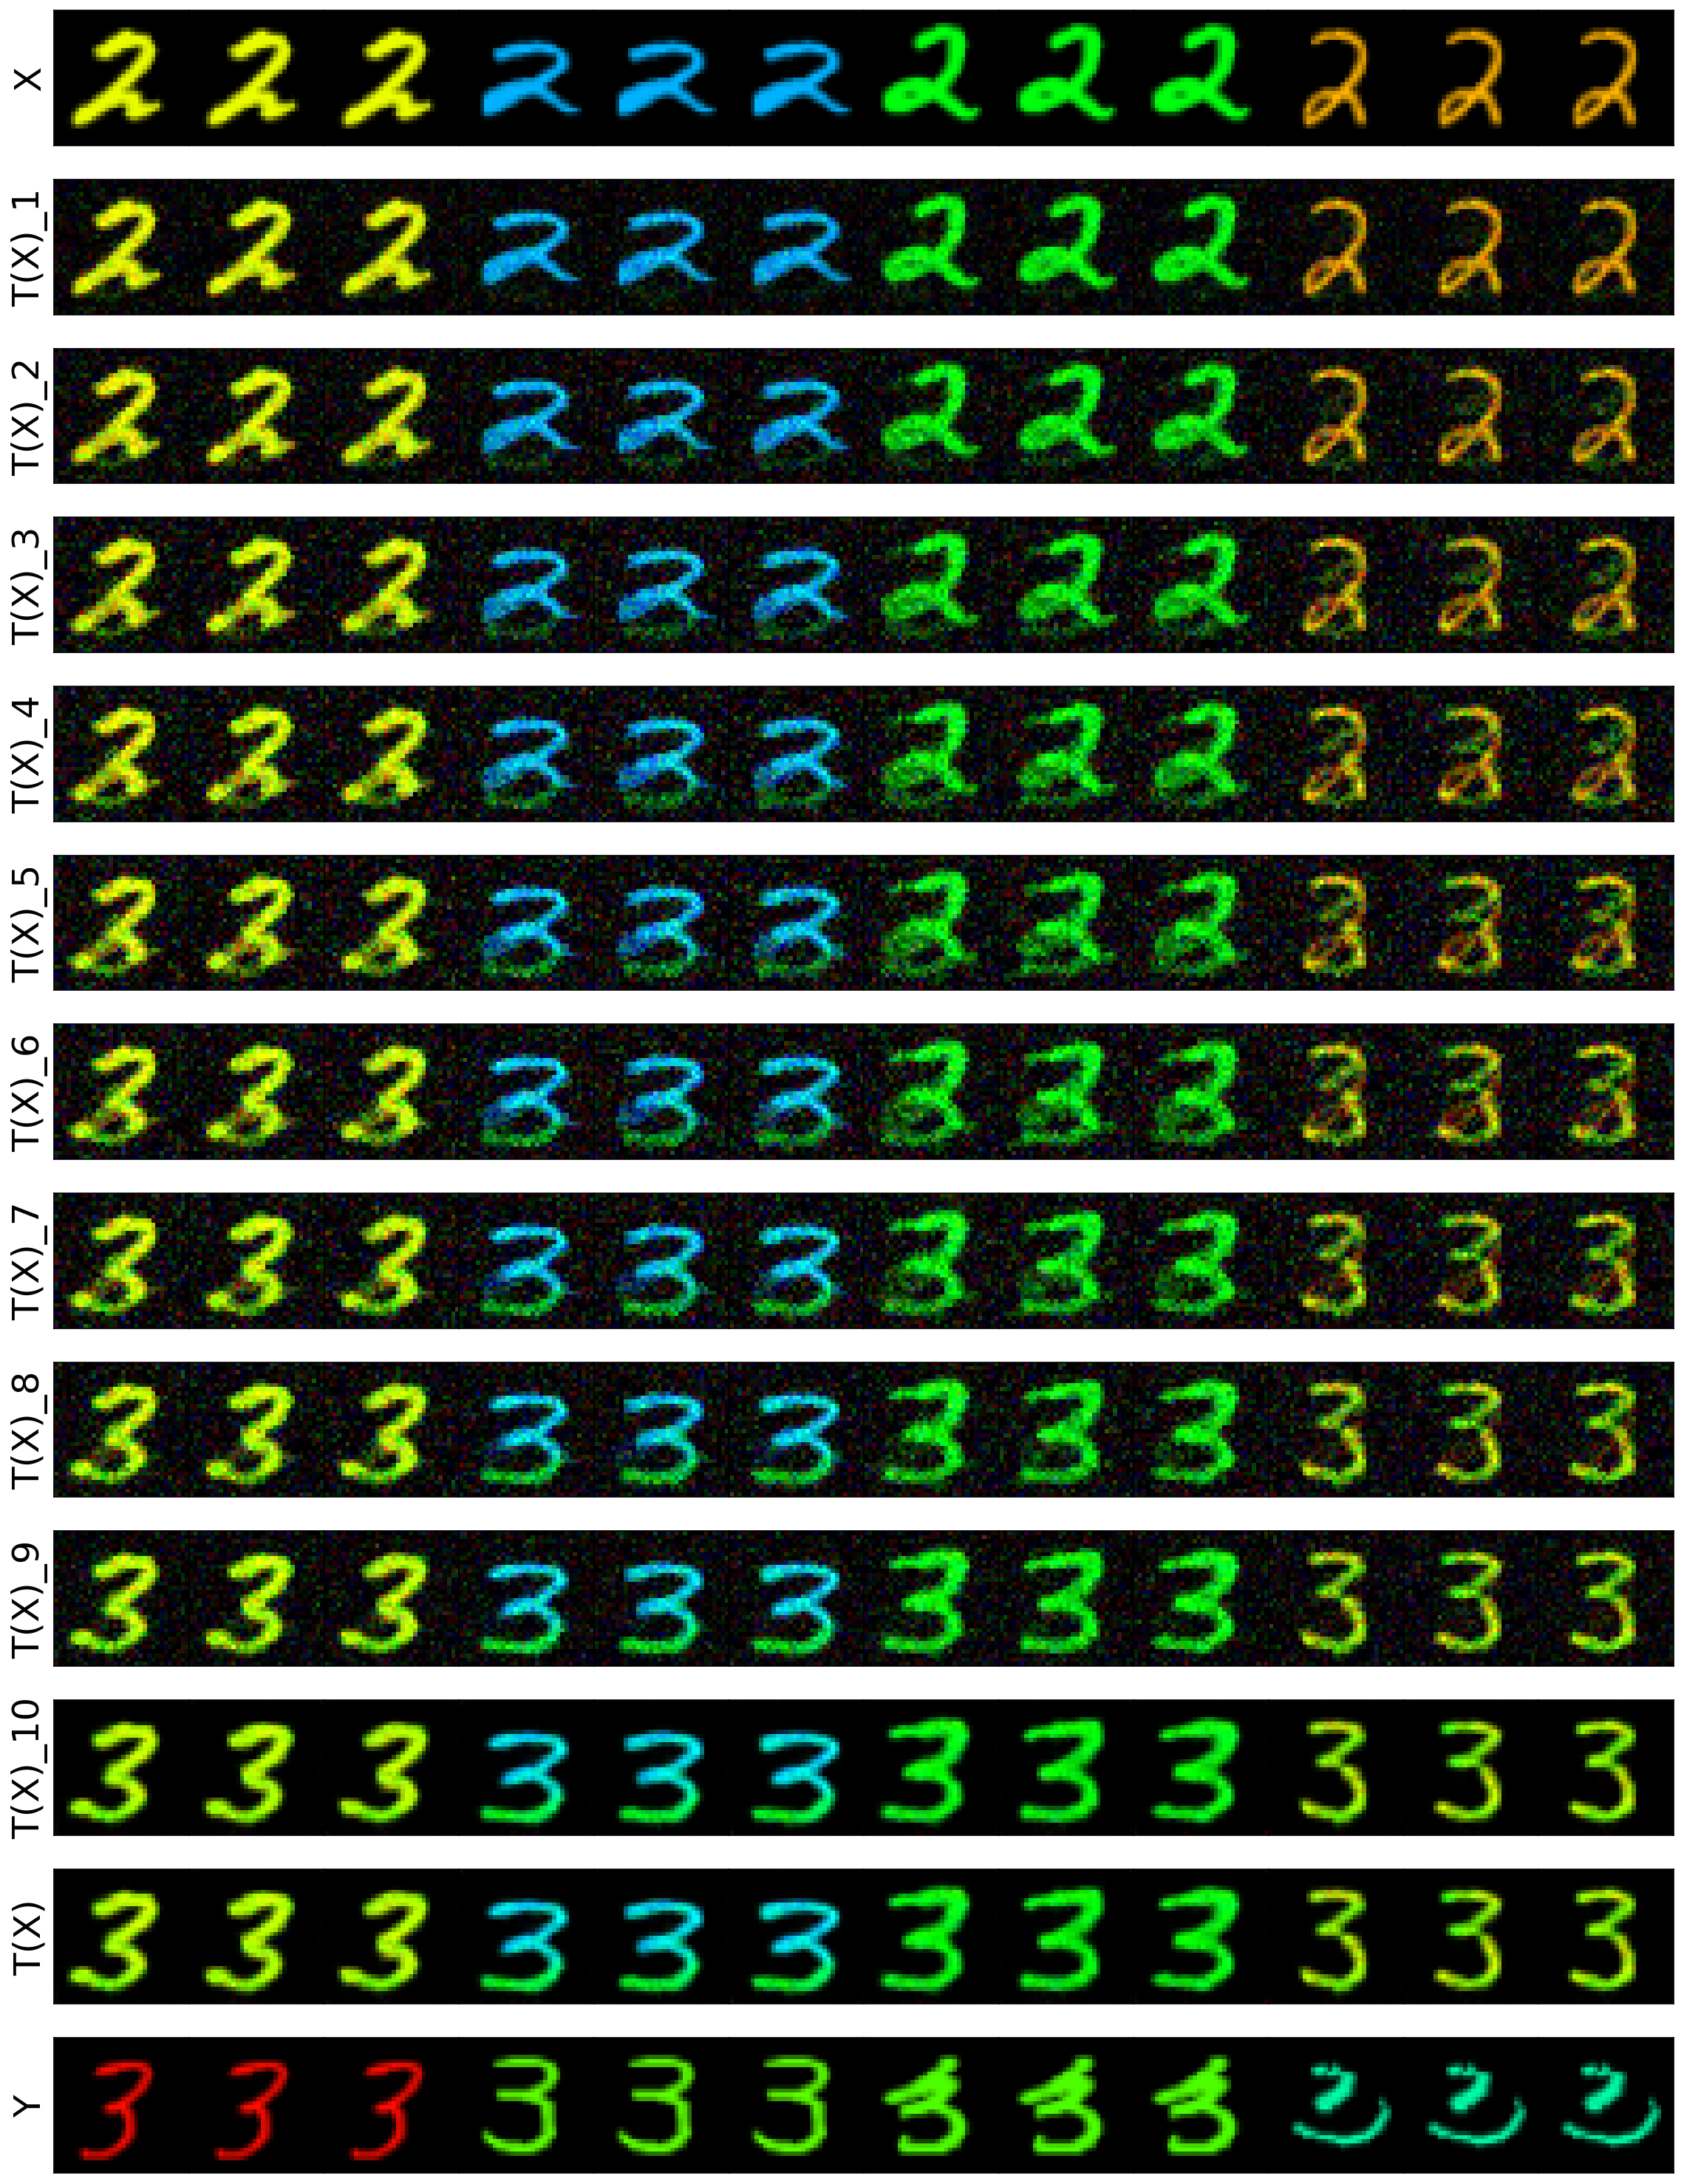

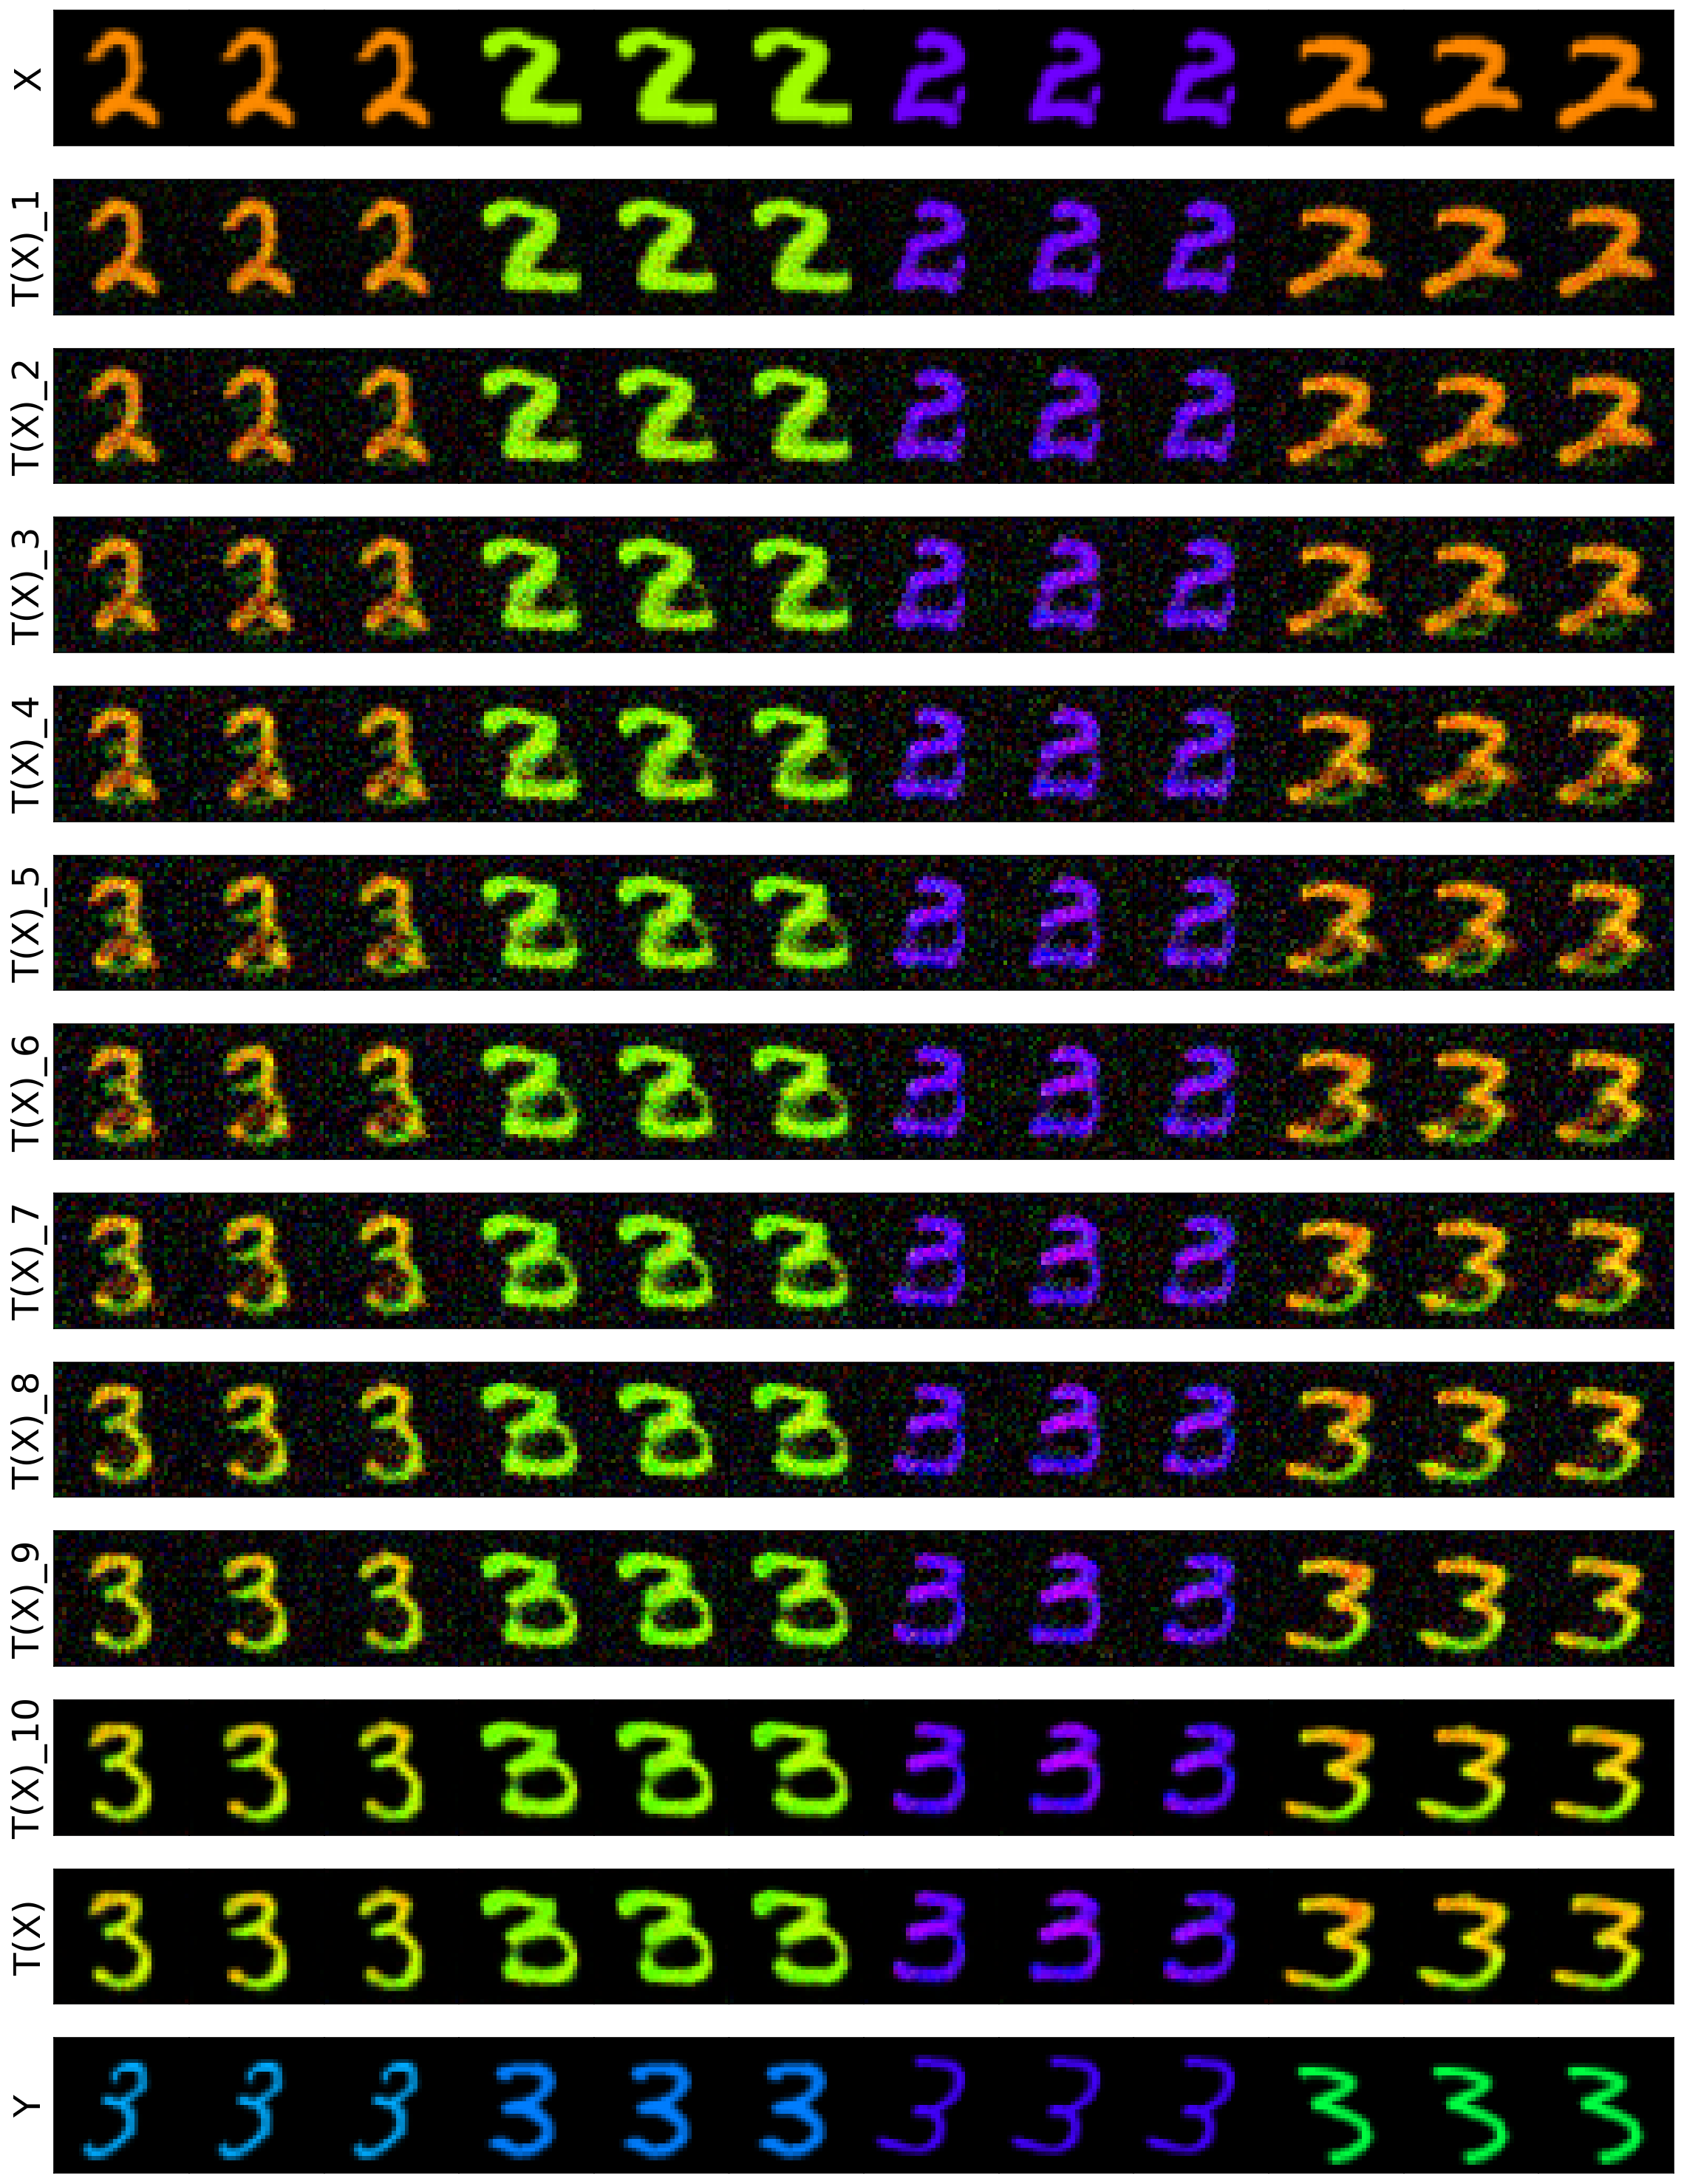

Computing FID


In [12]:
def epsilon_scheduler(step):
    return min(EPSILON, EPSILON * (step / EPSILON_SCHEDULER_LAST_ITER))


for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    unfreeze(T)
    freeze(D)
    T.train()

    new_epsilon = epsilon_scheduler(step)
    if len(DEVICE_IDS) > 1:
        T.module.set_epsilon(new_epsilon)
    else:
        T.set_epsilon(new_epsilon)
    # wandb.log({"Epsilon": new_epsilon}, step=step)

    for t_iter in range(T_ITERS):
        T_opt.zero_grad()

        X0, X1 = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
        X0.requires_grad_()

        trajectory, times, shifts = T(X0)
        XN = trajectory[:, -1]
        norm = torch.norm(shifts.flatten(start_dim=2), p=2, dim=-1) ** 2
        integral = INTEGRAL_SCALE * integrate(norm, times[0])

        T_loss = (integral + D(X1) - D(XN)).mean()
        T_loss.backward()
        T_gradient_norm = torch.nn.utils.clip_grad_norm_(
            T.parameters(), max_norm=T_GRADIENT_MAX_NORM
        )
        T_opt.step()

        if USE_EXPONENTIAL_AVERAGE_MODEL:
            ema_T.shift_model.update()

    # wandb.log({"T gradient norm": T_gradient_norm.item()}, step=step)
    wandb.log({"Mean norm": torch.sqrt(norm).mean().item()}, step=step)
    wandb.log({"T_loss": T_loss.item()}, step=step)

    T_scheduler.step()
    del T_loss, X0, X1, XN
    gc.collect()
    torch.cuda.empty_cache()

    freeze(T)
    unfreeze(D)

    D_opt.zero_grad()

    X0, X1 = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
    trajectory, times, shifts = T(X0)
    XN = trajectory[:, -1]
    norm = torch.norm(shifts.flatten(start_dim=2), p=2, dim=-1) ** 2
    integral = INTEGRAL_SCALE * integrate(norm, times[0])

    D_X1 = D(X1)
    D_XN = D(XN)

    D_loss = (-integral - D_X1 + D_XN).mean()
    D_loss.backward()
    D_gradient_norm = torch.nn.utils.clip_grad_norm_(
        D.parameters(), max_norm=D_GRADIENT_MAX_NORM
    )
    D_opt.step()
    D_scheduler.step()

    wandb.log({"D gradient norm": D_gradient_norm.item()}, step=step)
    wandb.log({"D_loss": D_loss.item()}, step=step)

    wandb.log({"integral": integral.mean().item()}, step=step)
    wandb.log({"D_X1": D_X1.mean().item()}, step=step)
    wandb.log({"D_XN": D_XN.mean().item()}, step=step)
    del D_loss, X0, X1, XN
    gc.collect()
    torch.cuda.empty_cache()

    if step % TRACK_VAR_INTERVAL == 0:
        trajectories = []
        X0 = X_sampler.sample(BATCH_SIZE)
        X1 = Y_sampler.sample(BATCH_SIZE)

        with torch.no_grad():
            for i in range(4):
                trajectory, times, shifts = T(X0)
                trajectories.append(trajectory.detach())

        trajectories = torch.stack(trajectories, dim=0)

        for i in range(1, trajectories.shape[2]):
            wandb.log(
                {f"T_{i} var": trajectories[:, :, i].var(dim=0).mean().item()},
                step=step,
            )

        for i in range(0, trajectories.shape[2]):
            wandb.log(
                {
                    f"T_{i} unconditional var": trajectories[0, :, i]
                    .var(dim=0)
                    .mean()
                    .item()
                },
                step=step,
            )

        for i in range(0, trajectories.shape[2]):
            wandb.log(
                {
                    f"T_{i} var of conditional mean": trajectories[:, :, i]
                    .mean(dim=0)
                    .var(dim=0)
                    .mean()
                    .item()
                },
                step=step,
            )

        T_var = trajectories[:, :, -1].var(dim=0).mean()
        wandb.log({"T var": T_var.item()}, step=step)

        T_unconditional_var = trajectories[0, :, -1].var(dim=0).mean()
        wandb.log({"T unconditional var": T_unconditional_var.item()}, step=step)

        X1_var = X1.var(dim=0).mean()
        wandb.log({"X_1 var": X1_var.item()}, step=step)

        if DATASET1_CHANNELS == 3:
            for i in range(0, trajectories.shape[2]):
                wandb.log(
                    {f"T_{i} red mean": trajectories[0, :, i, 0].mean().item()},
                    step=step,
                )
                wandb.log(
                    {f"T_{i} green mean": trajectories[0, :, i, 1].mean().item()},
                    step=step,
                )
                wandb.log(
                    {f"T_{i} blue mean": trajectories[0, :, i, 2].mean().item()},
                    step=step,
                )

            wandb.log({"X_1 red mean": X1[:, 0].mean().item()}, step=step)
            wandb.log({"X_1 green mean": X1[:, 1].mean().item()}, step=step)
            wandb.log({"X_1 blue mean": X1[:, 2].mean().item()}, step=step)

    if step % PLOT_INTERVAL == 0:
        print("Plotting")
        clear_output(wait=True)

        inference_T = T
        if USE_EXPONENTIAL_AVERAGE_MODEL:
            inference_T = ema_T

        inference_T.eval()

        fig, axes = plot_fixed_sde_images(
            X_fixed, Y_fixed, inference_T, gray=GRAY_PLOTS
        )
        wandb.log({"Fixed Images": [wandb.Image(fig2img(fig))]}, step=step)
        plt.show(fig)
        plt.close(fig)

        fig, axes = plot_random_sde_images(
            X_sampler, Y_sampler, inference_T, gray=GRAY_PLOTS
        )
        wandb.log({"Random Images": [wandb.Image(fig2img(fig))]}, step=step)
        plt.show(fig)
        plt.close(fig)

        fig, axes = plot_fixed_sde_images(
            X_test_fixed, Y_test_fixed, inference_T, gray=GRAY_PLOTS
        )
        wandb.log({"Fixed Test Images": [wandb.Image(fig2img(fig))]}, step=step)
        plt.show(fig)
        plt.close(fig)

        fig, axes = plot_random_sde_images(
            X_test_sampler, Y_test_sampler, inference_T, gray=GRAY_PLOTS
        )
        wandb.log({"Random Test Images": [wandb.Image(fig2img(fig))]}, step=step)
        plt.show(fig)
        plt.close(fig)

        if step >= ONE_STEP_INIT_ITERS:
            steps_to_draw = min(N_STEPS, 10)
            fig, axes = plot_fixed_sde_trajectories(
                X_fixed, Y_fixed, inference_T, STEPS_TO_SHOW, N_STEPS, gray=GRAY_PLOTS
            )
            wandb.log({"Fixed Trajectories": [wandb.Image(fig2img(fig))]}, step=step)
            plt.show(fig)
            plt.close(fig)

            fig, axes = plot_random_sde_trajectories(
                X_sampler,
                Y_sampler,
                inference_T,
                STEPS_TO_SHOW,
                N_STEPS,
                gray=GRAY_PLOTS,
            )
            wandb.log({"Random Trajectories": [wandb.Image(fig2img(fig))]}, step=step)
            plt.show(fig)
            plt.close(fig)

            fig, axes = plot_fixed_sde_trajectories(
                X_test_fixed,
                Y_test_fixed,
                inference_T,
                STEPS_TO_SHOW,
                N_STEPS,
                gray=GRAY_PLOTS,
            )
            wandb.log(
                {"Fixed Test Trajectories": [wandb.Image(fig2img(fig))]}, step=step
            )
            plt.show(fig)
            plt.close(fig)

            fig, axes = plot_random_sde_trajectories(
                X_test_sampler,
                Y_test_sampler,
                inference_T,
                STEPS_TO_SHOW,
                N_STEPS,
                gray=GRAY_PLOTS,
            )
            wandb.log(
                {"Random Test Trajectories": [wandb.Image(fig2img(fig))]}, step=step
            )
            plt.show(fig)
            plt.close(fig)

            fig, axes = plot_several_fixed_sde_trajectories(
                X_test_fixed,
                Y_test_fixed,
                inference_T,
                STEPS_TO_SHOW,
                N_STEPS,
                gray=GRAY_PLOTS,
            )
            wandb.log(
                {"Several Fixed Trajectories": [wandb.Image(fig2img(fig))]}, step=step
            )
            plt.show(fig)
            plt.close(fig)

            fig, axes = plot_several_random_sde_trajectories(
                X_test_sampler,
                Y_test_sampler,
                inference_T,
                STEPS_TO_SHOW,
                N_STEPS,
                gray=GRAY_PLOTS,
            )
            wandb.log(
                {"Several Random Trajectories": [wandb.Image(fig2img(fig))]}, step=step
            )
            plt.show(fig)
            plt.close(fig)

    if step % CPKT_INTERVAL == 0:
        inference_T = T
        if USE_EXPONENTIAL_AVERAGE_MODEL:
            inference_T = ema_T

        inference_T.eval()
        freeze(T)
        if len(DEVICE_IDS) > 1:
            torch.save(
                T.module.state_dict(), os.path.join(OUTPUT_PATH, f"T_{SEED}_{step}.pt")
            )
            torch.save(
                D.module.state_dict(), os.path.join(OUTPUT_PATH, f"D_{SEED}_{step}.pt")
            )
        else:
            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f"T_{SEED}_{step}.pt"))
            torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f"D_{SEED}_{step}.pt"))
        if USE_EXPONENTIAL_AVERAGE_MODEL:
            torch.save(
                ema_T.state_dict(), os.path.join(OUTPUT_PATH, f"ema_T_{SEED}_{step}.pt")
            )
        torch.save(
            D_opt.state_dict(), os.path.join(OUTPUT_PATH, f"D_opt_{SEED}_{step}.pt")
        )
        torch.save(
            T_opt.state_dict(), os.path.join(OUTPUT_PATH, f"T_opt_{SEED}_{step}.pt")
        )
        torch.save(
            D_scheduler.state_dict(),
            os.path.join(OUTPUT_PATH, f"D_scheduler_{SEED}_{step}.pt"),
        )
        torch.save(
            T_scheduler.state_dict(),
            os.path.join(OUTPUT_PATH, f"T_scheduler_{SEED}_{step}.pt"),
        )

        print("Computing FID")
        mu, sigma = get_sde_pushed_loader_stats(
            inference_T,
            X_test_sampler.loader,
            n_epochs=FID_EPOCHS,
            batch_size=BATCH_SIZE,
        )
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({"FID (Test)": fid}, step=step)
        del mu, sigma

    gc.collect()
    torch.cuda.empty_cache()

In [13]:
wandb.finish()